# Prediction 2 20231030

In [1]:
import os
import re
import torch
from transformers import AutoConfig, AutoModel, AutoTokenizer
import json
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import itertools
from rouge_chinese import Rouge
import jieba 



def load_glm_checkpoint(checkpoint_path, pre_seq_len=1024):
    llm_path = "/workspace/LLM"
    # Test local tokenizer 载入Tokenizer
    # tokenizer = AutoTokenizer.from_pretrained(llm_path, trust_remote_code=True)
    # config = AutoConfig.from_pretrained(llm_path, trust_remote_code=True, pre_seq_len=1024)
    
    config = AutoConfig.from_pretrained("THUDM/chatglm-6b", trust_remote_code=True, pre_seq_len=pre_seq_len)

    model = AutoModel.from_pretrained(llm_path, config=config, trust_remote_code=True)
    print("Parameter Merging!")
    prefix_state_dict = torch.load(os.path.join(checkpoint_path, "pytorch_model.bin"))

    new_prefix_state_dict = {}
    for k, v in prefix_state_dict.items():
        if k.startswith("transformer.prefix_encoder."):
            new_prefix_state_dict[k[len("transformer.prefix_encoder."):]] = v
    model.transformer.prefix_encoder.load_state_dict(new_prefix_state_dict)
    print("Model Quantizationing!")
    model = model.quantize(4)
    model = model.half().cuda()
    model.transformer.prefix_encoder.float()
    model = model.eval()
    print("Model Loaded!")
    return model


def classification_analysis(input_df_path, label_column_name, prediction_column_name):
    analysis_df_path = input_df_path.split('.')[0]+'_analysis.csv'
    input_df = pd.read_csv(input_df_path, encoding='utf-8-sig')

    cartesian_product = [str(a) + str(b) for a, b in itertools.product(['precision_', 'recall_', 'f1_score_'], ["無關", "摘要", "訴訟要件不足"])]
    if os.path.isfile(analysis_df_path):
        analysis_df = pd.read_csv(analysis_df_path, encoding='utf-8-sig')
    else:
        analysis_df = pd.DataFrame(columns=['ckpt_name', 'confusion_matrix', 'accuracy_score']+cartesian_product)

    y_tests = input_df[label_column_name].values.tolist()
    y_preds = input_df[prediction_column_name].values.tolist()

    conf_matrix = confusion_matrix(y_tests, y_preds, labels=["無關", "摘要", "訴訟要件不足"])

    # print('\n', prediction_column_name, ":")
    # print('-----------------')
    # print('DataFrame Length', len(input_df))
    # print(conf_matrix)
    
    # Metrics calculation
    acc = round(accuracy_score(y_tests, y_preds), 3)
    precision_values = precision_score(y_tests, y_preds, average=None, labels=["無關", "摘要", "訴訟要件不足"])
    recall_values = recall_score(y_tests, y_preds, average=None, labels=["無關", "摘要", "訴訟要件不足"])
    f1_values = f1_score(y_tests, y_preds, average=None, labels=["無關", "摘要", "訴訟要件不足"])

    # print()
    # print("accuracy_score", acc)
    # print("precision_score\n", *["{:.3f}  ".format(p) for p in precision_values])
    # print("recall_score\n", *["{:.3f}  ".format(p) for p in recall_values])
    # print("f1_score\n", *["{:.3f}  ".format(p) for p in f1_values])
    # print('-----------------')
    
    # Saving the metrics into analysis_df
    metrics_values = ["{:.3f}".format(p) for sublist in [precision_values, recall_values, f1_values] for p in sublist]
    analysis_df.loc[len(analysis_df)] = {'ckpt_name': prediction_column_name, 'confusion_matrix':conf_matrix, 'accuracy_score': acc, **dict(zip(cartesian_product, metrics_values))}

    # Save analysis_df to CSV
    analysis_df.to_csv(analysis_df_path, index=False, encoding='utf-8-sig')

def get_segmentation(input_text):
    return ' '.join(jieba.cut(input_text)) 
def rouge_analysis(output_path):
    rouge = Rouge()
    format_df = pd.read_csv(output_path, encoding='utf-8-sig')

    for index, row in format_df.iterrows():
        ori_summary = row['ori_summary']
        l_summary = row['l_summary']
        c_summary = row['c_summary']

        l_scores = rouge.get_scores(get_segmentation(l_summary), get_segmentation(ori_summary))
        c_scores = rouge.get_scores(get_segmentation(c_summary), get_segmentation(ori_summary))
        scores = {'l': l_scores, 'c': c_scores}
        metrics = ["rouge-1", "rouge-2", "rouge-l"]
        measures = ["p", "r", "f"]
        for col in ['l', 'c']:
            for metric in metrics:
                for measure in measures:
                    format_df.at[index, f'{col}_{metric}_{measure}'] = scores[col][0][metric][measure]
                    # format_df.at[index, f'c_{metric}_{measure}'] = c_scores[0][metric][measure]


    rounded = format_df.round(3)
    output_path = output_path.split('.')[0]+'_rouge.csv'
    rounded.to_csv(output_path, encoding='utf-8-sig', index = False)
    
# # 暫時用不到 ---Segementatioin between 事實(含) and 綜上所述、據上論斷
# def segement_between_fact_above(jud):
#     jud = jud.replace("\n", "").replace("\u3000", "").replace(" ","")
#     # result = re.findall(".+主 *文.+?(事 *實.+)(綜上所述|據上論斷)", jud)
#     result = re.search(".+主 *文.+?(事 *實.+)(綜上所述|據上論斷|爰.*?審酌)", jud)
#     if result:
#         result = result.group(1)
#     # print(len(result.groups()))
#     return result
# def segement_exceptions(jud):
#     jud = jud.replace("\n", "").replace("\u3000", "").replace(" ","")
#     result = re.search("(事 *實.+如不服.+?。)|(公訴不受理.+如\d*主\d*文)", jud)
#     if result:
#         result = result.group(result.lastindex)
#     return result

# def read_json(json_path):
#     with open(json_path, "r", encoding="utf-8-sig") as json_file:
#         # json_list = json_file.readlines()
#         json_list = [json.loads(line) for line in json_file]
#         keys = [key for key in json_list[0].keys()]
#         print(f"json length:{len(json_list)}\njson keys:{keys}")
#     return json_list

tokenizer = AutoTokenizer.from_pretrained("THUDM/chatglm-6b", trust_remote_code=True)


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


In [4]:
# Classification
import pandas as pd
from tqdm import tqdm
import random
from datetime import datetime
import pytz


# 需設定
ckpt_steps = 50
init_ckpt = 50
final_ckpt = 1000
# checkpoint_dir_path = "/workspace/output/20231026_classfication-chatglm-6b-pt-1024-2e-2-8000steps-positives-2400steps"
checkpoint_dir_path = "/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps"


taiwan = pytz.timezone('Asia/Taipei')
current_time = datetime.now(taiwan)
datetime = current_time.strftime('%Y%m%d-%H%M%S')
# cls_prediction_output_csv_path = '/workspace/FP/5_prediction/{}_8000steps_final{}steps_classification_predictions.csv'.format(datetime, final_ckpt)
cls_prediction_output_csv_path = '/workspace/FP/7_sixlabels_model_100juds_pos304_neg_608_total912sentences/{}_6labels_jud100_classification_model_p304ins23n739_sum966_predictions.csv'.format(datetime, final_ckpt)
classification_format_path = '/workspace/FP/3_classification_model/20231030_classification_predictions_format.csv'
classification_token_limit = 1000

testing_dataset = [180, 43, 64, 190, 206, 30, 17, 211, 157, 37, 214, 59, 205, 222, 268, 240, 60, 21, 207, 242, 101, 254, 48, 120, 78, 158]
classification_df = pd.read_csv(classification_format_path, encoding='utf-8-sig')
# for ckpt in tqdm(range(init_ckpt, final_ckpt+ckpt_steps, ckpt_steps)):
for ckpt in tqdm(range(final_ckpt, init_ckpt-ckpt_steps, -ckpt_steps)):

    merged_model = load_glm_checkpoint(checkpoint_dir_path+"/checkpoint-{}".format(ckpt), 1024)
    print(checkpoint_dir_path+"/checkpoint-{}".format(ckpt))
    for jud_index in testing_dataset:
        sub_df = classification_df[classification_df['jud_index']==jud_index]
        for index, row in sub_df.iterrows():
            sentence = classification_df.iloc[index]['sentence'][:classification_token_limit]
            label = classification_df.iloc[index]['label']
            prediction, history = merged_model.chat(tokenizer, sentence, history=[])
            summary_columns = ['事實', '爭點', '心證', '量刑考量']
            pred_trasnformation = prediction
            if prediction in summary_columns:
                pred_trasnformation = '摘要'
            # prediction = random.choice(['無關', '摘要', '訴訟要件不足'])
            if label==pred_trasnformation:
                error = False
            else:
                error = True
            classification_df.loc[index, '{}-6labels'.format(ckpt)] = prediction
            classification_df.loc[index, '{}-3labels_transformation-prediction'.format(ckpt)] = pred_trasnformation
            classification_df.loc[index, '{}-error'.format(ckpt)] = error
        classification_df.to_csv(cls_prediction_output_csv_path, encoding='utf-8-sig', index = False)
    classification_analysis(cls_prediction_output_csv_path, 'label', '{}-3labels_transformation-prediction'.format(ckpt))



  0%|          | 0/20 [00:00<?, ?it/s]

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [01:00<00:00,  7.54s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!


The dtype of attention mask (torch.int64) is not bool


Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-1000


  5%|▌         | 1/20 [06:27<2:02:37, 387.24s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-950


 10%|█         | 2/20 [12:05<1:47:31, 358.41s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.30s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-900


 15%|█▌        | 3/20 [17:27<1:36:47, 341.65s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.33s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-850


 20%|██        | 4/20 [22:46<1:28:43, 332.69s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-800


 25%|██▌       | 5/20 [28:00<1:21:30, 326.02s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.32s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-750


 30%|███       | 6/20 [33:17<1:15:21, 322.97s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-700


 35%|███▌      | 7/20 [38:34<1:09:31, 320.91s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.32s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-650


 40%|████      | 8/20 [43:52<1:04:03, 320.26s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-600


 45%|████▌     | 9/20 [49:09<58:29, 319.04s/it]  Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-550


 50%|█████     | 10/20 [54:25<53:01, 318.18s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.32s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-500


 55%|█████▌    | 11/20 [59:43<47:42, 318.10s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-450


 60%|██████    | 12/20 [1:05:01<42:25, 318.16s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.36s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-400


 65%|██████▌   | 13/20 [1:10:22<37:12, 318.91s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.31s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-350


 70%|███████   | 14/20 [1:15:40<31:52, 318.68s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-300


 75%|███████▌  | 15/20 [1:20:55<26:27, 317.58s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.29s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-250


 80%|████████  | 16/20 [1:26:12<21:09, 317.33s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-200


 85%|████████▌ | 17/20 [1:31:28<15:51, 317.12s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.31s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-150


 90%|█████████ | 18/20 [1:36:43<10:32, 316.47s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-100


 95%|█████████▌| 19/20 [1:41:57<05:15, 315.69s/it]Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.29s/it]
Some weights of ChatGLMForConditionalGeneration were not initialized from the model checkpoint at /workspace/LLM and are newly initialized: ['transformer.prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Parameter Merging!
Model Quantizationing!
Model Loaded!
/workspace/output/20231108_6labels_jud100_classification_model_p304ins23n739_sum966-1024-2e-2-1000steps/checkpoint-50


100%|██████████| 20/20 [1:47:11<00:00, 321.57s/it]


In [5]:
%cd /workspace/FP
!git add .
!git commit -m "add 6labels_jud100 predictions"
!git push origin main

/workspace/FP
[main 8f8de32] add 6labels_jud100 predictions
 3 files changed, 687 insertions(+), 1453 deletions(-)
 create mode 100644 7_sixlabels_model_100juds_pos304_neg_608_total912sentences/20231109-103154_6labels_jud100_classification_model_p304ins23n739_sum966_predictions.csv
 create mode 100644 7_sixlabels_model_100juds_pos304_neg_608_total912sentences/20231109-103154_6labels_jud100_classification_model_p304ins23n739_sum966_predictions_analysis.csv
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 24 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 60.00 KiB | 2.40 MiB/s, done.
Total 6 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/LawrenceCHH/FP.git
   b58ddbd..8f8de32  main -> main


In [3]:
classification_analysis('/workspace/FP/3_classification_model/20231028_8000_classification_predictions_full.csv', 'label', 'prediction'.format())

In [90]:
# Summarization
import pandas as pd

# 輸入最好的分類ckpt數字
target_ckpt_num = 50
format_csv_path = '/workspace/FP/4_summarization_model/20231030_1600_summarization_predictions_rouge_format.csv'
classification_csv_path = cls_prediction_output_csv_path
sum_output_path = cls_prediction_output_csv_path.split('.')[0]+f'-ckpt{target_ckpt_num}'+'_1600_summarization_predictions.csv'

format_df = pd.read_csv(format_csv_path, encoding='utf-8-sig')
cdf = pd.read_csv(classification_csv_path, encoding='utf-8-sig')
testing_dataset = [180, 43, 64, 190, 206, 30, 17, 211, 157, 37, 214, 59, 205, 222, 268, 240, 60, 21, 207, 242, 101, 254, 48, 120, 78, 158]

for jud_index in testing_dataset:
   
    subc_df = cdf[cdf['jud_index']==jud_index]
    subc_df = subc_df[subc_df[f'{target_ckpt_num}-prediction'].isin(['摘要', '訴訟要件不足'])]
    
    c_content = ''.join(subc_df['sentence'].values.tolist())
    if len(c_content) == 0:
        c_prediction = "輸入為空"
    else:
        # c_prediction, history = merged_model.chat(tokenizer, c_content, history=[])
        c_prediction = "c"
    format_df.loc[format_df['jud_index']==jud_index, 'classified'] = c_content
    format_df.loc[format_df['jud_index']==jud_index, 'c_summary'] = c_prediction
    format_df.to_csv(sum_output_path, encoding='utf-8-sig', index = False)

rouge_analysis(sum_output_path)

# Preprocessing 2 20231019

In [8]:
import matplotlib.pyplot as plt
import json
import pandas as pd

def read_glm_json(file_path):
    with open(file_path, "r", encoding="utf-8") as json_file:
        data, labels = zip(*[[json.loads(line)['content'], json.loads(line)['summary']] for line in json_file])
    return [data, labels]
def output_list_to_csv(des_csv_path, input_list):
    df = pd.DataFrame({'content': input_list[0], 'summary': input_list[1]})
    df.to_csv(des_csv_path, index=False, encoding='utf-8-sig')
    return df
def draw_datasets_bar(dataset_list, dataset_name):
    lengths = [len(s) for s in dataset_list]
    average_lengths = sum(lengths)/len(lengths)
    sorted_lengths = sorted(lengths)
    max_lengths = sorted_lengths[-1]
    min_lengths = sorted_lengths[0]
    print(dataset_name)
    print(f"average: {average_lengths}")
    print(f"max: {max_lengths}")
    print(f"min: {min_lengths}")

    # Create a histogram of the string lengths
    plt.bar(range(len(dataset_list)), lengths)

    # Add labels and title
    plt.xlabel('Strings')
    plt.ylabel('Length')
    plt.title(f'Length of strings in {dataset_name}')

    # Add tick labels for x-axis
    # First arg means location, Second arg means label on that location
    plt.xticks(range(len(lengths)), range(len(lengths)))

    # Show the plot
    plt.show()
def over_length(text_length, dataset):
    
    return sum([1 for content in dataset if len(content) > text_length])

Text length>250: 18
Text length>500: 3
Text length>750: 0
Text length>1000: 0
Text length>1500: 0
Text length>2000: 0
9
train_summarization
average: 338.9230769230769
max: 698
min: 69


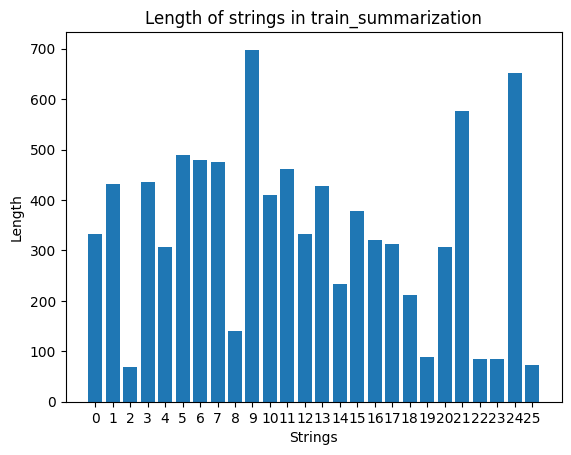

In [16]:
# 20231109 test
train_path = '/workspace/FP/7_sixlabels_model_100juds_pos304_neg_608_total912sentences/20231109_6labels_jud100_preds_jud240summarization_testing.json'
train = read_glm_json(train_path)
content = train[1]
print("Text length>250:", over_length(250, content))
print("Text length>500:", over_length(500, content))
print("Text length>750:", over_length(750, content))
print("Text length>1000:", over_length(1000, content))
print("Text length>1500:", over_length(1500, content))
print("Text length>2000:", over_length(2000, content))
the_longest = max((len(text), index) for index, text in enumerate(content))[1]
print(the_longest)
draw_datasets_bar(content, "train_summarization")

Text length>250: 237
Text length>500: 225
Text length>750: 192
Text length>1000: 116
Text length>1500: 27
Text length>2000: 10
26
train_summarization
average: 1044.9541666666667
max: 2772
min: 165


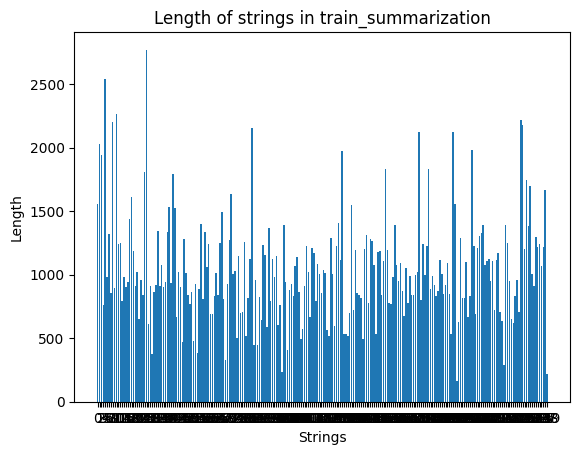

In [12]:
# 20231109 content
train_path = '/workspace/FP/7_sixlabels_model_100juds_pos304_neg_608_total912sentences/20231109_6labels_jud100_preds_jud240summarization_training.json'
train = read_glm_json(train_path)
content = train[0]
print("Text length>250:", over_length(250, content))
print("Text length>500:", over_length(500, content))
print("Text length>750:", over_length(750, content))
print("Text length>1000:", over_length(1000, content))
print("Text length>1500:", over_length(1500, content))
print("Text length>2000:", over_length(2000, content))
the_longest = max((len(text), index) for index, text in enumerate(content))[1]
print(the_longest)
draw_datasets_bar(content, "train_summarization")

Text length>250: 200
Text length>500: 77
Text length>750: 20
Text length>1000: 6
Text length>1500: 1
Text length>2000: 0
0
train_summarization
average: 446.0625
max: 1610
min: 55


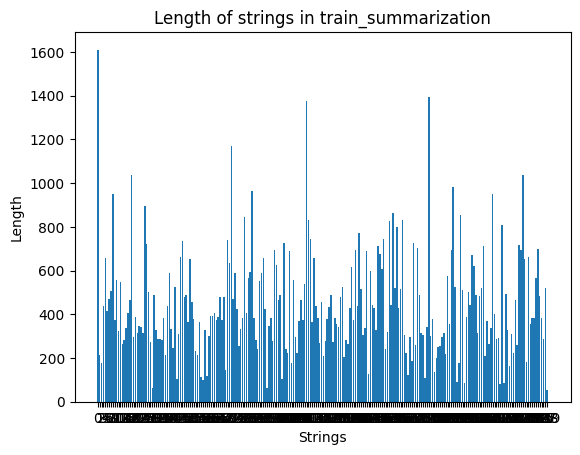

In [10]:
# 20231109 summary
train_path = '/workspace/FP/7_sixlabels_model_100juds_pos304_neg_608_total912sentences/20231109_6labels_jud100_preds_jud240summarization_training.json'
train = read_glm_json(train_path)
content = train[1]
print("Text length>250:", over_length(250, content))
print("Text length>500:", over_length(500, content))
print("Text length>750:", over_length(750, content))
print("Text length>1000:", over_length(1000, content))
print("Text length>1500:", over_length(1500, content))
print("Text length>2000:", over_length(2000, content))
the_longest = max((len(text), index) for index, text in enumerate(content))[1]
print(the_longest)
draw_datasets_bar(content, "train_summarization")

Text length>250: 220
Text length>500: 161
Text length>750: 90
Text length>1000: 27
Text length>1500: 6
Text length>2000: 3
181
train_summarization
average: 662.375
max: 2400
min: 63


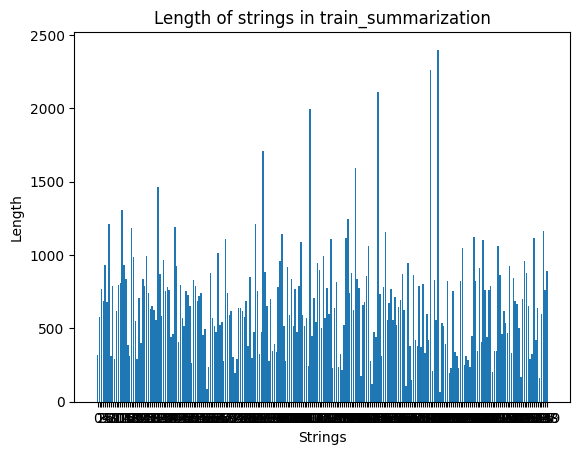

In [5]:
train_path = '/workspace/FP/4_summarization_model/20231028_merge_replaced_human_updated_splitted_auto_labeled_summarization_training.json'
train = read_glm_json(train_path)
content = train[0]
print("Text length>250:", over_length(250, content))
print("Text length>500:", over_length(500, content))
print("Text length>750:", over_length(750, content))
print("Text length>1000:", over_length(1000, content))
print("Text length>1500:", over_length(1500, content))
print("Text length>2000:", over_length(2000, content))
the_longest = max((len(text), index) for index, text in enumerate(content))[1]
print(the_longest)
draw_datasets_bar(content, "train_summarization")

Text length>250: 199
Text length>500: 77
Text length>750: 20
Text length>1000: 6
Text length>1500: 1
Text length>2000: 0
177
train_summarization
average: 445.4875
max: 1610
min: 55


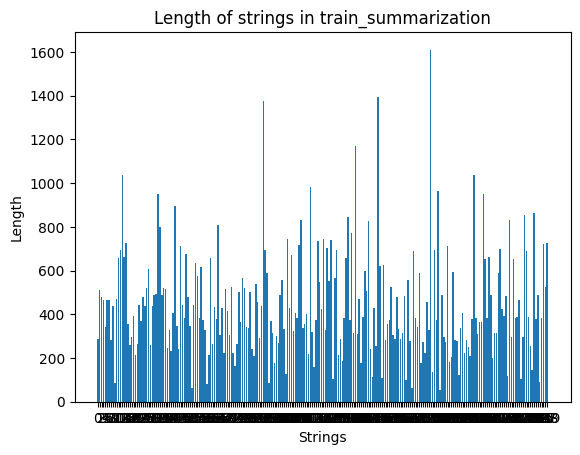

In [6]:
train_path = '/workspace/FP/4_summarization_model/20231028_merge_replaced_human_updated_splitted_auto_labeled_summarization_training.json'
train = read_glm_json(train_path)
summary = train[1]
print("Text length>250:", over_length(250, summary))
print("Text length>500:", over_length(500, summary))
print("Text length>750:", over_length(750, summary))
print("Text length>1000:", over_length(1000, summary))
print("Text length>1500:", over_length(1500, summary))
print("Text length>2000:", over_length(2000, summary))
the_longest = max((len(text), index) for index, text in enumerate(summary))[1]
print(the_longest)
draw_datasets_bar(summary, "train_summarization")

Text length>250: 617
Text length>500: 85
Text length>750: 8
Text length>1000: 2
347
train_content
average: 114.95953382971835
max: 1296
min: 1


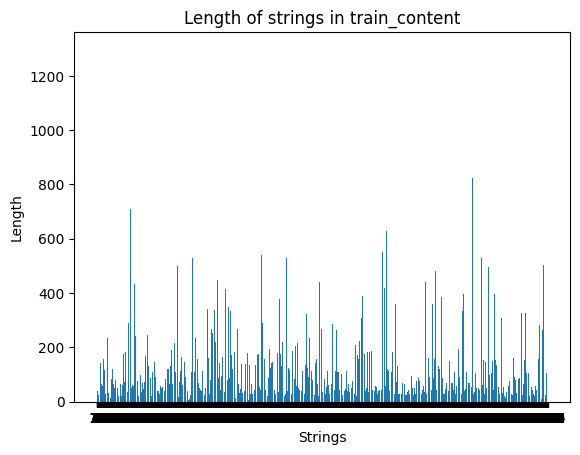

In [8]:
train_path = '/workspace/FP/3_classification_model/20230419_merge_replaced_human_updated_splitted_auto_labeled_classfication_dataset_training.json'
train = read_glm_json(train_path)
content = train[0]
print("Text length>250:", over_length(250, content))
print("Text length>500:", over_length(500, content))
print("Text length>750:", over_length(750, content))
print("Text length>1000:", over_length(1000, content))
the_longest = max((len(text), index) for index, text in enumerate(content))[1]
print(the_longest)
draw_datasets_bar(content, "train_content")

## glm json儲存成csv檔

In [1]:
import json
import pandas as pd

def read_glm_json(file_path):
    with open(file_path, "r", encoding="utf-8") as json_file:
        data, labels = zip(*[[json.loads(line)['content'], json.loads(line)['summary']] for line in json_file])
    return [data, labels]
def output_list_to_csv(des_csv_path, input_list):
    df = pd.DataFrame({'content': input_list[0], 'summary': input_list[1]})
    df.to_csv(des_csv_path, index=False, encoding='utf-8-sig')
    return df



file_path = '/workspace/FP/1_program_annotated/20230419_merge_replaced.json'
csv_path = '/workspace/FP/20230419_merge_replaced.csv'

# glm_list = read_glm_json(file_path)
# print(len(glm_list))
# # glm_df = output_list_to_csv(csv_path, glm_list)
# print(glm_list[1][70])
train_path = '/workspace/FP/3_classification_model/20230419_merge_replaced_human_updated_splitted_auto_labeled_classfication_dataset_training.json'
train = read_glm_json(train_path)
print(len(train[0]))

6178


## 將content拆解成句，存成csv或excel

In [128]:
import re
from tqdm import tqdm
csv_path = '/workspace/PF/20230419_merge_replaced_human_updated_splitted.csv'
xlsx_path = '/workspace/PF/20230419_merge_replaced_human_updated_splitted.xlsx'
contents = pd.read_csv('/workspace/FP/human_annotated/20230419_merge_replaced_human_updated.csv', encoding='utf-8-sig')['content'].to_list()

df = pd.DataFrame(columns=['jud_index', 'sentence', 'label', 'summary'])
for index, data in enumerate(tqdm(contents)):
    sentences = re.findall(r'.*?。', data)
    for sentence in sentences:
        df.loc[len(df)] = {'jud_index': index, 'sentence': sentence}
df.index.name = 'csv_index'        
df.to_csv(csv_path, encoding='utf-8-sig')
# df.to_excel(xlsx_path, index=False)

100%|██████████| 269/269 [00:10<00:00, 26.67it/s]


In [ ]:
# import json
# dataset_name = "20230419_merge_replaced.json"
# def print_jud(input_text, char_num=60):
#   num = 0
#   text = ""
#   for c in input_text:
#     text+=c
#     num+=1
#     if num==char_num:
#       text+="\n"
#       # print(text)
#       # text=""
#       num=0
#   # text += "\n-----------\n"
#   return text
#   # print(text)
# def read_glm_dataset(file_name):
#     with open(file_name, "r", encoding="utf-8") as json_file:
#         glm_dataset = [json.loads(line) for line in json_file]
#     return glm_dataset
    
# def output_glm_datast(file_name, dataset):
#     with open(file_name, "w", encoding="utf-8") as json_file:
#         for line in dataset:
#             json_file.write(json.dumps(line,ensure_ascii=False))
#             json_file.write("\n")

## rouge-l > 0.85 自動標註

In [37]:
# !pip install rouge-chinese jieba
from rouge_chinese import Rouge
import jieba # you can use any other word cutting library
import re
from tqdm import tqdm
def get_segmentation(input_text):
    return ' '.join(jieba.cut(input_text)) 

In [49]:
labeled_df = pd.read_csv('/workspace/FP/20230419_merge_replaced_human_updated_splitted.csv', encoding='utf-8-sig')
# labels = read_glm_json(file_path)[1]
labels = pd.read_csv('/workspace/FP/human_annotated/20230419_merge_replaced_human_updated.csv', encoding='utf-8-sig')['summary'].to_list()

output_path = '/workspace/FP/20230419_merge_replaced_human_updated_splitted_auto_labeled.csv'
record_path = '/workspace/FP/20230419_merge_replaced_human_updated_splitted_auto_labeled_record.csv'
record_df = pd.DataFrame(columns=['jud_index', 'remaining_sentences_nums', 'sentences'])
record_df.index.name = 'no'
jud_end = 268
unlabeled_start_index = labeled_df[labeled_df['summary'].isna()==True].iloc[0]['jud_index']
print('The nearest unlabeled index: ', unlabeled_start_index)
rouge = Rouge()

for jud_index in tqdm(range(unlabeled_start_index, jud_end+1)):
    jud_df = labeled_df[labeled_df['jud_index']==jud_index]
    label = labels[jud_index].strip('摘要如下：')
    # label_splitted = re.findall(r'.*?。', label)
    label_splitted = label.split('。')
    label_splitted = [label+'。' for label in label_splitted if label]
    # print(label_splitted)
    # print(len(label_splitted))
    for index, row in jud_df.iterrows():
        scores = []
        if label_splitted==[]:
            labeled_df.at[index, 'summary'] = '-1'
            continue
        for sentence in label_splitted:
            rouge_score_l = rouge.get_scores(get_segmentation(row['sentence']), get_segmentation(sentence))[0]['rouge-l']['r']
            scores.append(rouge_score_l)
        if max(scores) > 0.85:
            max_score_index = scores.index(max(scores))
            labeled_df.at[index, 'summary'] = label_splitted[max_score_index]
            del label_splitted[max_score_index]
        else:
            labeled_df.at[index, 'summary'] = '-1'
    record_df.loc[len(record_df)] = {'jud_index': jud_index, 'remaining_sentences_nums': len(label_splitted), 'sentences': label_splitted}
    labeled_df.to_csv(output_path, encoding='utf-8-sig', index=False)
    record_df.to_csv(record_path, encoding='utf-8-sig')



The nearest unlabeled index:  0


100%|██████████| 269/269 [01:25<00:00,  3.16it/s]


# Draw judgement length

# 檢查不受理判決

In [35]:
from tqdm import tqdm
import re
juds = pd.read_excel('/workspace/FP/2_human_annotated/20230419_merge_replaced_human_updated.xlsx')
two = []
for index in tqdm(range(len(juds))):
    content = juds.iloc[index]['content']
    founded = re.findall('不\d*?受\d*?理\d*?之\d*?判\d*?決', content)
    if len(founded)>0 and index != 70:
        two.append(index)
print(two)
print(len(two))

100%|██████████| 269/269 [00:00<00:00, 22869.06it/s]

[30, 33, 64, 65, 66, 103, 111, 142, 211, 213, 218, 238, 240, 241, 242, 267, 268]
17


# 將欄位summary中文文字標籤(-1、1、2、x)轉成1

In [38]:
input_df = pd.read_excel('/workspace/FP/2_human_annotated/20230419_merge_replaced_human_updated_splitted_auto_labeled - classfication.xlsx')
output_path = '/workspace/FP/2_human_annotated/20230419_merge_replaced_human_updated_splitted_auto_labeled - classfication - training.csv'
for index in tqdm(range(len(input_df))):
    if input_df.iloc[index]['summary']==-1:
        input_df.loc[index, 'summary'] = '無關'
    elif input_df.iloc[index]['summary']==1:
        input_df.loc[index, 'summary'] = '摘要'
    elif input_df.iloc[index]['summary']==2:
        input_df.loc[index, 'summary'] = '訴訟要件不足'
    elif input_df.iloc[index]['summary']=='x':
        input_df.loc[index, 'summary'] = '排除'
    else:
        input_df.loc[index, 'summary'] = '摘要'
input_df.to_csv(output_path, encoding='utf-8-sig', index=False)


100%|██████████| 6800/6800 [00:01<00:00, 3586.56it/s]


# 製作glm dataset

In [51]:
import random
summaries = []
input_df = pd.read_csv('/workspace/FP/2_human_annotated/20230419_merge_replaced_human_updated_splitted_auto_labeled - classfication - training.csv', encoding='utf-8-sig')

summaries = list(set(input_df[input_df['summary']=='摘要']['jud_index'].to_list()))
excludes = list(set(input_df[input_df['summary']=='排除']['jud_index'].to_list()))
unsufficient = list(set(input_df[input_df['summary']=='訴訟要件不足']['jud_index'].to_list()))
print(len(summaries)+len(excludes)+len(unsufficient))

random.shuffle(unsufficient)
random.shuffle(summaries)
test_unsufficient = unsufficient[:6]
test_summaries = summaries[:20]
print(test_unsufficient)
print(test_summaries)


269
[242, 30, 211, 64, 268, 240]
[158, 60, 206, 180, 120, 48, 78, 207, 254, 214, 37, 157, 17, 21, 190, 43, 205, 101, 222, 59]


In [52]:
test_unsufficient = [242, 30, 211, 64, 268, 240]
test_summaries = [158, 60, 206, 180, 120, 48, 78, 207, 254, 214, 37, 157, 17, 21, 190, 43, 205, 101, 222, 59]
train_summaries = [index for index in summaries if index not in test_summaries]
train_unsufficient = [index for index in unsufficient if index not in test_unsufficient]
print(len(test_summaries)+len(train_summaries))
print(len(test_unsufficient)+len(train_unsufficient))

249
17


In [65]:
import json
input_df = pd.read_csv('/workspace/FP/2_human_annotated/20230419_merge_replaced_human_updated_splitted_auto_labeled - classfication - training.csv', encoding='utf-8-sig')
training_dataset = train_summaries+train_unsufficient
random.shuffle(training_dataset)
training_dataset = [36, 217, 53, 122, 142, 249, 19, 96, 130, 241, 6, 100, 252, 20, 257, 185, 258, 250, 22, 72, 41, 147, 172, 121, 76, 42, 174, 167, 186, 3, 110, 243, 8, 175, 138, 266, 177, 46, 67, 61, 91, 28, 104, 169, 165, 221, 140, 166, 79, 25, 33, 162, 82, 204, 264, 149, 150, 35, 238, 1, 4, 13, 137, 58, 239, 179, 163, 248, 154, 5, 191, 144, 181, 246, 232, 31, 55, 261, 228, 26, 233, 220, 97, 134, 124, 133, 237, 152, 125, 151, 99, 218, 231, 189, 2, 195, 132, 188, 10, 88, 160, 127, 176, 223, 11, 18, 105, 251, 126, 156, 141, 235, 203, 210, 170, 70, 9, 52, 12, 86, 168, 244, 187, 98, 81, 111, 92, 107, 62, 236, 184, 260, 129, 90, 77, 153, 27, 83, 50, 84, 215, 23, 161, 7, 171, 113, 65, 148, 87, 194, 224, 192, 108, 14, 208, 123, 47, 155, 265, 143, 45, 38, 24, 263, 66, 117, 135, 103, 159, 259, 193, 85, 116, 139, 119, 57, 164, 0, 197, 209, 74, 94, 267, 225, 118, 32, 229, 256, 145, 93, 39, 106, 182, 16, 73, 114, 146, 199, 230, 136, 253, 131, 247, 63, 128, 234, 255, 95, 51, 54, 198, 202, 226, 44, 262, 102, 71, 227, 69, 178, 201, 56, 40, 75, 109, 49, 183, 216, 115, 219, 200, 80, 173, 196, 34, 213, 89, 29, 212, 112]
with open('20230419_merge_replaced_human_updated_splitted_auto_labeled - classfication_dataset_training.json', 'w') as jfile:
    for index in training_dataset:
        sub_df = input_df[input_df['jud_index']==index]
        for sub_index, row in sub_df.iterrows():
            output_data = {'content': input_df.iloc[sub_index]['sentence'], 'summary': input_df.iloc[sub_index]['summary']}
            jfile.write(json.dumps(output_data, ensure_ascii=False)+'\n')



In [110]:
testing_dataset = test_summaries+test_unsufficient
random.shuffle(testing_dataset)
testing_dataset = [180, 43, 64, 190, 206, 30, 17, 211, 157, 37, 214, 59, 205, 222, 268, 240, 60, 21, 207, 242, 101, 254, 48, 120, 78, 158]

with open('20230419_merge_replaced_human_updated_splitted_auto_labeled - classfication_dataset_testing.json', 'w') as jfile:
    for index in testing_dataset:
        sub_df = input_df[input_df['jud_index']==index]
        for sub_index, row in sub_df.iterrows():
            output_data = {'content': input_df.iloc[sub_index]['sentence'], 'summary': input_df.iloc[sub_index]['summary']}
            jfile.write(json.dumps(output_data, ensure_ascii=False)+'\n')


# Summarization Model Dataset

In [11]:
import json
import pandas as pd
input_df = pd.read_csv('/workspace/FP/2_human_annotated/20230419_merge_replaced_human_updated_splitted_auto_labeled - classfication - training.csv', encoding='utf-8-sig')
# training_dataset = train_summaries+train_unsufficient
# random.shuffle(training_dataset)
training_dataset = [36, 217, 53, 122, 142, 249, 19, 96, 130, 241, 6, 100, 252, 20, 257, 185, 258, 250, 22, 72, 41, 147, 172, 121, 76, 42, 174, 167, 186, 3, 110, 243, 8, 175, 138, 266, 177, 46, 67, 61, 91, 28, 104, 169, 165, 221, 140, 166, 79, 25, 33, 162, 82, 204, 264, 149, 150, 35, 238, 1, 4, 13, 137, 58, 239, 179, 163, 248, 154, 5, 191, 144, 181, 246, 232, 31, 55, 261, 228, 26, 233, 220, 97, 134, 124, 133, 237, 152, 125, 151, 99, 218, 231, 189, 2, 195, 132, 188, 10, 88, 160, 127, 176, 223, 11, 18, 105, 251, 126, 156, 141, 235, 203, 210, 170, 70, 9, 52, 12, 86, 168, 244, 187, 98, 81, 111, 92, 107, 62, 236, 184, 260, 129, 90, 77, 153, 27, 83, 50, 84, 215, 23, 161, 7, 171, 113, 65, 148, 87, 194, 224, 192, 108, 14, 208, 123, 47, 155, 265, 143, 45, 38, 24, 263, 66, 117, 135, 103, 159, 259, 193, 85, 116, 139, 119, 57, 164, 0, 197, 209, 74, 94, 267, 225, 118, 32, 229, 256, 145, 93, 39, 106, 182, 16, 73, 114, 146, 199, 230, 136, 253, 131, 247, 63, 128, 234, 255, 95, 51, 54, 198, 202, 226, 44, 262, 102, 71, 227, 69, 178, 201, 56, 40, 75, 109, 49, 183, 216, 115, 219, 200, 80, 173, 196, 34, 213, 89, 29, 212, 112]
summaries = pd.read_excel('/workspace/FP/3_classification_model/20230419_merge_replaced.xlsx')['summary'].to_list()
with open('/workspace/FP/4_summarization_model/20230419_merge_replaced_human_updated_splitted_auto_labeled_summarization_training.json', 'w') as jfile:
    for index in training_dataset:
        sub_df = input_df[input_df['jud_index']==index]
        sub_df = sub_df[sub_df['summary'].isin(['摘要', '訴訟要件不足'])]
        content = ''.join(sub_df['sentence'].to_list())
        summary = summaries[index].strip('摘要如下：')
        output_data = {'content': content, 'summary': summary}
        jfile.write(json.dumps(output_data, ensure_ascii=False)+'\n')
print(len(training_dataset))

240


In [21]:
testing_dataset = [180, 43, 64, 190, 206, 30, 17, 211, 157, 37, 214, 59, 205, 222, 268, 240, 60, 21, 207, 242, 101, 254, 48, 120, 78, 158]

with open('/workspace/FP/4_summarization_model/20230419_merge_replaced_human_updated_splitted_auto_labeled_summarization_testing.json', 'w') as jfile:
    for index in testing_dataset:
        sub_df = input_df[input_df['jud_index']==index]
        sub_df = sub_df[sub_df['summary'].isin(['摘要', '訴訟要件不足'])]
        content = ''.join(sub_df['sentence'].to_list())
        summary = summaries[index].strip('摘要如下：')
        output_data = {'content': content, 'summary': summary}
        jfile.write(json.dumps(output_data, ensure_ascii=False)+'\n')
print(len(testing_dataset))


26


In [24]:
json_path ='/workspace/FP/4_summarization_model/20230419_merge_replaced_human_updated_splitted_auto_labeled_summarization_training.json'
json_path ='/workspace/FP/4_summarization_model/20230419_merge_replaced_human_updated_splitted_auto_labeled_summarization_testing.json'
jlist = read_glm_json(json_path)
print(len(jlist[0]))
print(jlist[0][1].split('。'))
print(jlist[1][1].split('。'))

26
['12事實及理由13一、犯罪事實：莊璧華於民國一一０年二月七日十二時二十七分14許，駕駛車牌號碼000-○○○○號自用小客車，沿臺南市安15南區安和路二段由北往南方向行駛，行經臺南市安南區安和16路二段與安和路二段一七四巷路口，本應注意車前狀況，且17後車與前車之間應保持隨時可以煞停之安全距離，而依當時18天候晴、日間自然光線、柏油路面乾燥、無缺陷等情形，並19無不能注意之情事，竟疏未注意車前狀況，亦未保持安全距20離，適有蘇世銘駕駛車牌號碼○○○○-0○號自用小客車搭21載黃惠娟，在上開路口停等紅燈，遭同向後方駛至之莊璧華22駕駛該自用小客車碰撞，蘇世銘之上開自用小客車復往前碰23撞同向前方在該路口停等紅燈之孫小明駕駛車牌號碼000-○24○○○號自用小客車，致黃惠娟受有頭部鈍傷、頸部挫傷及25下背挫傷之傷害', '爰審酌被告17駕駛自小客車未隨時注意車前狀況及未保持與前車安全車18距、致告訴人受有如犯罪事實欄所載之傷害、尚未與告訴人19達成民事和解賠償損害，惟告訴人已提起附帶民事訴訟、無20前科素行良好及其犯後態度等一切情狀，量處如主文所示之21刑，併諭知易科罰金之折算標準', '']
['莊璧華駕駛車牌號碼沿臺南市安南區安和路二段由北往南方向行駛，行經臺南市安南區安和16路二段與安和路二段一七四巷路口，本應注意車前狀況，然竟疏未注意車前狀況，亦未保持安全距離，適有蘇世銘駕駛車牌號碼○○○○-0○號自用小客車搭載黃惠娟，在上開路口停等紅燈，遭同向後方駛至之莊璧華駕駛該自用小客車碰撞，蘇世銘之上開自用小客車復往前碰撞同向前方在該路口停等紅燈之孫小明駕駛之自用小客車，致黃惠娟受有頭部鈍傷、頸部挫傷及下背挫傷之傷害', '本院爰審酌被告駕駛自小客車未隨時注意車前狀況及未保持與前車安全車距、致告訴人受有如犯罪事實欄所載之傷害、尚未與告訴人達成民事和解賠償損害，量處如主文所示之刑，併諭知易科罰金之折算標準', '']


# 製作classification dataset (只有摘要、訴訟要件不足) 效果不好

In [69]:
import pandas as pd
import json
train_json_path = '/workspace/FP/3_classification_model/20230419_merge_replaced_human_updated_splitted_auto_labeled_classfication_dataset_training.json'
total_df_path = '/workspace/FP/2_human_annotated/20230419_merge_replaced_human_updated_splitted_auto_labeled - classfication - training.csv'
training_dataset = [36, 217, 53, 122, 142, 249, 19, 96, 130, 241, 6, 100, 252, 20, 257, 185, 258, 250, 22, 72, 41, 147, 172, 121, 76, 42, 174, 167, 186, 3, 110, 243, 8, 175, 138, 266, 177, 46, 67, 61, 91, 28, 104, 169, 165, 221, 140, 166, 79, 25, 33, 162, 82, 204, 264, 149, 150, 35, 238, 1, 4, 13, 137, 58, 239, 179, 163, 248, 154, 5, 191, 144, 181, 246, 232, 31, 55, 261, 228, 26, 233, 220, 97, 134, 124, 133, 237, 152, 125, 151, 99, 218, 231, 189, 2, 195, 132, 188, 10, 88, 160, 127, 176, 223, 11, 18, 105, 251, 126, 156, 141, 235, 203, 210, 170, 70, 9, 52, 12, 86, 168, 244, 187, 98, 81, 111, 92, 107, 62, 236, 184, 260, 129, 90, 77, 153, 27, 83, 50, 84, 215, 23, 161, 7, 171, 113, 65, 148, 87, 194, 224, 192, 108, 14, 208, 123, 47, 155, 265, 143, 45, 38, 24, 263, 66, 117, 135, 103, 159, 259, 193, 85, 116, 139, 119, 57, 164, 0, 197, 209, 74, 94, 267, 225, 118, 32, 229, 256, 145, 93, 39, 106, 182, 16, 73, 114, 146, 199, 230, 136, 253, 131, 247, 63, 128, 234, 255, 95, 51, 54, 198, 202, 226, 44, 262, 102, 71, 227, 69, 178, 201, 56, 40, 75, 109, 49, 183, 216, 115, 219, 200, 80, 173, 196, 34, 213, 89, 29, 212, 112]
total_df = pd.read_csv(total_df_path, encoding='utf-8-sig')

sub_df = total_df[total_df['jud_index'].isin(training_dataset)]
sub_df = sub_df[sub_df['summary'].isin(['摘要', '訴訟要件不足'])]

# with open('/workspace/FP/3_classification_model/20230419_merge_replaced_human_updated_splitted_auto_labeled_classfication_dataset_training_positives.json', 'w') as json_file:
#     for index, row in sub_df.iterrows():
#         json_file.write(json.dumps({'content': row['sentence'], 'summary': row['summary']}, ensure_ascii=False)+'\n')





# 製作classification dataset (無關4，摘要、訴訟要件不足1)

In [ ]:
import pandas as pd
import json
import random
# train_json_path = '/workspace/FP/3_classification_model/20230419_merge_replaced_human_updated_splitted_auto_labeled_classfication_dataset_training.json'
total_df_path = '/workspace/FP/2_human_annotated/20230419_merge_replaced_human_updated_splitted_auto_labeled - classfication - training.csv'
output_path = '/workspace/FP/3_classification_model/20231030_merge_replaced_human_updated_splitted_auto_labeled_classfication_dataset_training_pos1neg4.json'
training_dataset = [36, 217, 53, 122, 142, 249, 19, 96, 130, 241, 6, 100, 252, 20, 257, 185, 258, 250, 22, 72, 41, 147, 172, 121, 76, 42, 174, 167, 186, 3, 110, 243, 8, 175, 138, 266, 177, 46, 67, 61, 91, 28, 104, 169, 165, 221, 140, 166, 79, 25, 33, 162, 82, 204, 264, 149, 150, 35, 238, 1, 4, 13, 137, 58, 239, 179, 163, 248, 154, 5, 191, 144, 181, 246, 232, 31, 55, 261, 228, 26, 233, 220, 97, 134, 124, 133, 237, 152, 125, 151, 99, 218, 231, 189, 2, 195, 132, 188, 10, 88, 160, 127, 176, 223, 11, 18, 105, 251, 126, 156, 141, 235, 203, 210, 170, 70, 9, 52, 12, 86, 168, 244, 187, 98, 81, 111, 92, 107, 62, 236, 184, 260, 129, 90, 77, 153, 27, 83, 50, 84, 215, 23, 161, 7, 171, 113, 65, 148, 87, 194, 224, 192, 108, 14, 208, 123, 47, 155, 265, 143, 45, 38, 24, 263, 66, 117, 135, 103, 159, 259, 193, 85, 116, 139, 119, 57, 164, 0, 197, 209, 74, 94, 267, 225, 118, 32, 229, 256, 145, 93, 39, 106, 182, 16, 73, 114, 146, 199, 230, 136, 253, 131, 247, 63, 128, 234, 255, 95, 51, 54, 198, 202, 226, 44, 262, 102, 71, 227, 69, 178, 201, 56, 40, 75, 109, 49, 183, 216, 115, 219, 200, 80, 173, 196, 34, 213, 89, 29, 212, 112]
total_df = pd.read_csv(total_df_path, encoding='utf-8-sig')

result = []
for jud_index in training_dataset:
    sub_df = total_df[total_df['jud_index']==jud_index]
    negs = [[jud_index, row['sentence'], row['summary']] for index, row in sub_df[sub_df['summary']=='無關'].iterrows()]
    pos = [[jud_index, row['sentence'], row['summary']] for index, row in sub_df[sub_df['summary'].isin(['摘要', '訴訟要件不足'])].iterrows()]
    random.shuffle(negs)
    result+=negs[:4]
    result+=pos
    
print(len(result))
df = pd.DataFrame(columns=['jud_index', 'content', 'summary'])

# with open(output_path, 'w') as json_file:
#     for jud_index, sentence, label in result:
#         json_file.write(json.dumps({'content': sentence, 'summary': label}, ensure_ascii=False)+'\n')
#         df.loc[len(df)] = {'jud_index':jud_index, 'content': sentence, 'summary': label}
# df.to_csv('/workspace/FP/3_classification_model/20231030_merge_replaced_human_updated_splitted_auto_labeled_classfication_dataset_training_pos1neg4.csv', encoding='utf-8-sig', index=False)


1667


# Prediction

In [ ]:
import os
import re
import torch
from transformers import AutoConfig, AutoModel, AutoTokenizer
import json
import pandas as pd
from tqdm import tqdm
def load_glm_checkpoint(checkpoint_path):
    llm_path = "F:\\Lawrence\\ChatGLM-6B\\LLM"
    # Test local tokenizer 载入Tokenizer
    # tokenizer = AutoTokenizer.from_pretrained(llm_path, trust_remote_code=True)
    # config = AutoConfig.from_pretrained(llm_path, trust_remote_code=True, pre_seq_len=1024)
    
    config = AutoConfig.from_pretrained("THUDM/chatglm-6b", trust_remote_code=True, pre_seq_len=1024)

    model = AutoModel.from_pretrained(llm_path, config=config, trust_remote_code=True)
    print("Parameter Merging!")
    prefix_state_dict = torch.load(os.path.join(checkpoint_path, "pytorch_model.bin"))

    new_prefix_state_dict = {}
    for k, v in prefix_state_dict.items():
        if k.startswith("transformer.prefix_encoder."):
            new_prefix_state_dict[k[len("transformer.prefix_encoder."):]] = v
    model.transformer.prefix_encoder.load_state_dict(new_prefix_state_dict)
    print("Model Quantizationing!")
    model = model.quantize(4)
    model = model.half().cuda()
    model.transformer.prefix_encoder.float()
    model = model.eval()
    print("Model Loaded!")
    return model

# ---Segementatioin between 事實(含) and 綜上所述、據上論斷
def segement_between_fact_above(jud):
    jud = jud.replace("\n", "").replace("\u3000", "").replace(" ","")
    # result = re.findall(".+主 *文.+?(事 *實.+)(綜上所述|據上論斷)", jud)
    result = re.search(".+主 *文.+?(事 *實.+)(綜上所述|據上論斷|爰.*?審酌)", jud)
    if result:
        result = result.group(1)
    # print(len(result.groups()))
    return result
def segement_exceptions(jud):
    jud = jud.replace("\n", "").replace("\u3000", "").replace(" ","")
    result = re.search("(事 *實.+如不服.+?。)|(公訴不受理.+如\d*主\d*文)", jud)
    if result:
        result = result.group(result.lastindex)
    return result
# def read_json(json_path):
#     with open(json_path, "r", encoding="utf-8-sig") as json_file:
#         # json_list = json_file.readlines()
#         json_list = [json.loads(line) for line in json_file]
#         keys = [key for key in json_list[0].keys()]
#         print(f"json length:{len(json_list)}\njson keys:{keys}")
#     return json_list

# json_source_path = r"F:\Lawrence\ChatGLM-6B\ptuning\datasets\20230618_dataset_glm_400_testing.json"
# checkpoint_path = r"F:\Lawrence\ChatGLM-6B\ptuning\output\20230618_hackson_3600-6b-pt-1024-2e-2\checkpoint-{}"
# test_list = read_json(json_source_path)

input_text_list = ['''
裁判字號：臺灣新竹地方法院 111 年簡上字第 109 號民事判決
臺灣新竹地方法院民事判決
111年度簡上字第109號
上  訴  人  陳麗華 
訴訟代理人  蔡頤奕律師
被上訴人    峰華國際不動產有限公司

法定代理人  許清淵 
上列當事人間請求損害賠償事件，上訴人對於中華民國111年7月14日本院新竹簡易庭111年度竹簡字第175號第一審判決提起上訴，本院合議庭於112年5月24日言詞辯論終結，判決如下：
    主  文
上訴駁回。
第二審訴訟費用由上訴人負擔。
    事實及理由
壹、程序部分
　　    按在第二審為訴之變更或追加，非經他造同意，不得為之，但請求之基礎事實同一、擴張或減縮應受判決事項之聲明者，不在此限，民事訴訟法第446條第1項、第255條第1項第2款、第3款定有明文。上訴人於原審原請求被上訴人給付仲介費用新台幣(下同)204,000元、代書費用22,500元，原審審理後，判決上訴人敗訴，上訴人提起上訴後，於本院縮減其請求，僅就上訴人未調查並告知房屋瑕疵致上訴人客浴（即上訴人書狀中主張之客臥衛浴、客廳廁所，下稱客浴）漏水維修費用之瑕疵，依不完全給付之法律關係，請求被上訴人給付125,000元（見本院卷第77至79頁）。被上訴人未表示不同意，且其聲明部分，僅係縮減應受判決事項之聲明，依前開規定，其所為之變更，應予准許，先此敘明。
貳、實體部分：
一、上訴人於原審及本院主張：上訴人經由被上訴人之居間仲介，於民國110年4月14日向訴外人謝佳曄（下稱謝佳曄）購買門牌號碼新竹市○○路000巷000號6樓房屋（下稱系爭房屋）及其坐落基地暨停車位3個（編號50、51、32），並包含屋內之一切設備，總價為新臺幣（下同）1,020萬元，上訴人與謝佳曄於同日簽訂不動產買賣契約書（下稱系爭買賣契約）。詎系爭房屋客浴採乾濕分離，「乾區」部分無防水設計，倘經正常如廁清潔使用，將導致上訴人用水滲漏至5樓住戶，進而引發鄰損事件，致上訴人需另行雇工完成防水工程。謝佳曄竟於出售時惡意未告知上情，於系爭房屋標的物現況說明書15「現況是否有滲漏水情形」、16「是否曾在最近一年內修復甚漏水」勾選「否」，表示謝佳曄擔保系爭建物絕無滲漏水現象，且為被上訴人居間前進行屋況調查時所肯認，顯見被上訴人於居間出售系爭房屋時並未善盡調查義務，上訴人自得依民法第227條第1項不完全給付之法律關係，就上開防免漏水所施作之工程費用125,000元請求被上訴人為損害賠償。
二、被上訴人於原審及本院之答辯：被上訴人已盡善良管理之注意義務檢查買賣標的物，實無欺罔之情。蓋被上訴人於委售階段即已派員就出賣人所載之標的物現況說明書等47項以通常方法、肉眼所視及身體感知所及之方式逐一查驗，並製作不動產說明書以備買賣雙方於簽立系爭買賣契約時確認，上訴人於帶看時亦未發現漏水之情；另於驗屋及交屋階段，上訴人在產權移轉登記後、交屋前，曾再次前往驗屋，即以通常方法檢查屋況確認無誤後，通知貸款銀行代清償出賣人首順位銀行抵押權，可證自簽約後至驗屋時，被上訴人就滲漏水調查義務並無過失。而於交屋後階段，依統計資料所示，110年度國人月平均每戶用水費為224元，系爭房屋自110年4月14日簽約時起至同年10月14日止，用水費分別為132元（110年4月14日至110年6月10日共58天）、621元（110年6月11日至110年8月13日共64天）、1,008元（110年8月14日至110年10月14日共62天），扣除銷售帶看期間，如被上訴人確有隱匿或未盡調查義務致有漏水之情，即在110年6月11日至110年8月13日用水期間即生上情。承上，系爭房屋自驗屋日至交屋後之110年10月7日並無漏水情事等語。
三、原審經審理後，為上訴人敗訴之判決，上訴人不服提起上訴，上訴聲明：（一）原判決廢棄。（二）被上訴人應給付上訴人125,000元。被上訴人答辯聲明：上訴駁回。　　
四、兩造不爭執事項
（一）上訴人於110年4月12日簽訂「買方給付服務費承諾書」，委託被上訴人居間仲介購買系爭房屋，同意於契約成立時，給付買賣總價百分之二服務報酬予被上訴人。
（二）上訴人經由被上訴人之居間仲介，於110年4月14日向謝佳曄購買系爭房屋及其坐落基地暨停車位3個（編號50、51、32），並包含屋內之一切設備，總價為1,020萬元。系爭房屋標的物現況說明書15「現況是否有滲漏水情形」、16「是否曾在最近一年內修復甚漏水」處勾選「否」。
（三）上訴人曾於110年4月16日支付服務費204,000元予被上訴人。
（四）買賣雙方於110年6月2日辦理交屋手續，於此之前，上訴人已交付買賣價金，謝佳曄已移轉系爭不動產所有權登記，上訴人於110年7月間曾委由證人徐英洲進行主浴部分裝修，並110年9月入住。
（五）系爭房屋第一次登記日期為87年10月17日。　　
（六）上訴人於110年8月10日就仲介費服務爭議，向新竹市政府提起申訴，請求退還仲介報酬，另對被上訴人負責人提起刑事詐欺罪告訴，經台灣新竹地方檢察署檢察官以111年度偵字第6045號不起訴處分書為不起訴處分確定。　　
五、本院之判斷
　　    本件上訴人所為前揭主張，經被上訴人否認，並以前詞置辯。是本件主要爭點為：上訴人主張謝佳曄明知系爭房屋客浴採乾濕分離，「乾區」部分無防水設計，經正常如廁清潔使用，將導致上訴人用水滲漏至5樓住戶，進而引發鄰損事件，竟於出售時惡意未告知上情，且被上訴人未盡調查義務，致上訴人需另行雇工完成防水工程，應負擔修繕費用，是否有理由？如被上訴人應負擔前開修繕費用，則上訴人請求被上訴人給付125,000元，是否有理由？
（一）按當事人主張有利於己之事實者，就其事實有舉證之責任，民事訴訟法第277條前段定有明文。又民事訴訟如係由原告主張權利者，應先由原告負舉證之責，若原告先不能舉證，以證實自己主張之事實為真實，則被告就其抗辯事實即令不能舉證，或其所舉證據尚有疵累，亦應駁回原告之請求。經查，上訴人固主張：系爭房屋客浴乾區未為防水設計，造成系爭房屋樓下之5樓浴室漏水云云，並提出現場相片、報價單（見本院卷第55至58頁、第67頁、第83至84頁，原審卷第145頁）為佐。然查：系爭房屋自110年4月14日簽立買賣契約起，用水費分別為132元（110年4月14日至110年6月10日）、621元（110年6月11日至110年8月13日）、1,008元（110年8月14日至110年10月14日）、1156元（110年10月15日至12月13日）、968元（110年12月14日至111年2月10日），買賣雙方於110年6月2日交屋，上訴人於他案自承於9月間搬入系爭房屋（見本院111竹簡84號卷276頁），則系爭房屋水費於上訴人住居於系爭房屋後，始有明顯增加之情形，被上訴人所為前揭答辯，實屬有據。再查，本案起訴前，上訴人與他人間LINE通訊對話中，未曾提到「系爭房屋有滲漏水至5樓」等語（原審卷第121至134頁），而依上訴人於原審提出之施工費用請款收據（原審卷第45頁）、報價單（本院卷第67頁）細項中，均無修復5樓浴室之工項，證人徐英洲於原審中亦證稱：「主浴有做刨除、防水、貼地壁磚、浴缸。客浴部分只有換衛浴的零組配件，如把手、水龍頭。客浴部分有無漏水到樓下，我不清楚。」等語（原審卷第211至213頁），依證人徐英洲所言，亦無法證明系爭房屋客浴有滲漏水至5樓之情，上訴人前揭主張，難認與事實相符。再查，上訴人於民事補正起訴狀固稱：「5樓住戶於110年10月7日晚間反應系爭房屋浴室嚴重漏水到5樓，5樓住戶曾反應以前有漏水過，被上訴人在賣房子前有請抓漏師傅以灌膠方式處理漏水、、、」（原審卷第17頁）等語，然就此部分，上訴人未能提出任何積極證據佐證其說，依上訴人所提出之照片（本院卷第55至58頁、第83至84頁頁），亦無從認定系爭房屋客浴室有滲漏水至5樓之情形，而經本院詢問後，上訴人表示5樓住戶無意願出庭作證（本院卷第88頁），上訴人未能舉證證明系爭房屋客浴乾區未為防水設計，造成系爭房屋樓下之5樓浴室漏水等情，先予敘明。
（二）按仲介業務，係指從事不動產買賣、互易、租賃之居間或代理業務。不動產經紀業管理條例第4 條第5 款定有明文。又稱居間者，謂當事人約定，一方為他方報告訂約之機會或為訂約之媒介，他方給付報酬之契約；居間人關於訂約事項，應就其所知，據實報告於各當事人；以居間為營業者，關於訂約事項，有調查之義務。民法第565 條、第567 條亦規定甚明。然查，本件上訴人未能證明系爭房屋客浴有其所主張之瑕疵，業如前述，本件既無法認定系爭房屋有瑕疵問題，遑論被上訴人預見此瑕疵危險，或未調查、據實報告此瑕疵，故上訴人主張被上訴人就系爭房屋客浴「乾區」部分無防水設計，未依民法第567條為據實報告及調查，應負損害賠償責任云云，為無理由。
六、綜上所述，上訴人依民法第227條第1項規定，請求被上訴人負擔債務不履行之不完全給付責任，而請求被上訴人給付修繕客浴費用125,000元，為無理由，應予駁回。原審為上訴人敗訴之判決，並無不合，上訴意旨指摘原審判決不當，求予廢棄改判，為無理由，應駁回其上訴。
七、本件事證已臻明確，兩造其餘攻擊防禦方法及證據，核與判決之結果不生影響，爰不一一論列，併此敘明。
八、據上論結，本件上訴為無理由，依民事訴訟法第436條之1第3項、第449條第1項、第78條，判決如主文。　　　　　
中　　華　　民　　國　　112 　年　　6 　　月　　27　　日
                  民事第一庭  審判長  法　官  林南薰

                                      法  官  林麗玉

                                      法  官　張詠晶　　
本件正本證明與原本無異。
不得上訴。  　　　　　　　　　　　　　　　　　　　
中　　華　　民　　國　　112 　年　　6 　　月　　27　　日
                                      書記官  陳佩瑩
''',
'''
裁判字號：臺灣高雄地方法院 111 年交易字第 8 號刑事判決
臺灣高雄地方法院刑事判決
111年度交易字第8號
公  訴  人  臺灣高雄地方檢察署檢察官
被      告  吳三明



上列被告因過失傷害案件，經檢察官提起公訴（110年度偵字第13102號），本院判決如下：
    主  文
吳三明犯過失傷害罪，處拘役伍拾日，如易科罰金，以新臺幣壹仟元折算壹日。
    事  實
一、吳三明於民國110年1月27日上午11時54分許，騎乘電動自行車，自高雄市鳳山區龍成路123巷與保泰路之交叉路口（下稱前開路口）東南角、鄰近斑馬線交界處之路旁起駛，本應注意起駛前應注意左右有無車輛，並讓行進中之車輛優先通行，而依當時天候晴、日間自然光線、柏油路面乾燥無缺陷及障礙物、視距良好，客觀上並無不能注意之情事，竟疏未注意及此，貿然起駛而由西南往東北方向斜切駛入保泰路，欲沿保泰路由西往東方向行駛；適有余丞富騎乘車牌號碼000-0000號普通重型機車沿保泰路由西往東方向直行而來，見狀閃避不及，兩車遂發生碰撞，致余丞富人車倒地，受有左手腕扭拉傷、左肘擦傷4X2公分、左膝擦傷3X3公分、左小腿擦傷5X2公分、4X1.5公分、左足背擦傷2X2公分之傷害（下稱前開傷勢）。嗣吳三明肇事後，於有偵查犯罪權限之機關未發覺犯罪前，向前往醫院處理之員警坦承為肇事人，進而接受裁判。
二、案經余丞富訴由高雄市政府警察局鳳山分局報告臺灣高雄地方檢察署檢察官偵查起訴。 
    理  由
一、證據能力：
　㈠刑事訴訟法第159條之2規定，被告以外之人於檢察事務官、司法警察官或司法警察調查中所為之陳述，與審判中不符時，其先前之陳述具有較可信之特別情況，且為證明犯罪事實存否所必要者，得為證據。經查，證人即告訴人余丞富（下稱告訴人）於警詢、檢察事務官詢問中之證述，既經被告吳三明否認證據能力，又告訴人於警詢、檢察事務官詢問中證述內容，與其審判中所述大致相符，依照前揭規定，本院認其於警詢、檢察事務官詢問中之證詞應無證據能力。
　㈡除前開告訴人於警詢、檢察事務官詢問中之陳述外，檢察官、被告對於本判決後引各項屬於審判外陳述之證據，均同意有證據能力（見審交易卷第31頁），本院審酌該等證據資料製作時之情況，並無違法不當之瑕疵，認為以之作為證據應屬適當，依刑事訴訟法第159 條之5 第1 項規定，認該等證據資料均有證據能力。
二、事實認定之理由：
　㈠訊據被告吳三明固不否認有於前揭時間騎乘前開電動自行車，與告訴人所騎乘前開機車發生碰撞之事實，惟矢口否認有何過失傷害犯行，辯稱：我有回頭查看，確認告訴人機車離我尚有50公尺之距離，始起駛進入保泰路西向東之車道，我當時已完成右轉進入車道，告訴人應有注意到我，係告訴人自己超速，其應減速以防免車禍發生云云。
　㈡經查，被告於110年1月27日上午11時54分許，騎乘電動自行車，自前開路口東南角、鄰近斑馬線交界處之路旁起駛，由西南往東北方向斜切駛入保泰路，欲沿保泰路由西往東方向行駛；適有告訴人騎乘車牌號碼000-0000號普通重型機車沿保泰路由西往東方向直行而來，見狀閃避不及，兩車遂發生碰撞，致告訴人人車倒地，受有前開傷勢等事實，業據告訴人於本院審理中證述綦詳（見院卷第27至29頁），復有道路交通事故現場圖、道路交通事故調查報告表㈠㈡-1、現場照片、杏和醫院診斷證明書、本院現場監視器檔案勘驗筆錄及擷取照片等在卷可稽（見警卷第15、31至52頁；院卷第25、26、37至43頁），並為被告所是認（見院卷第33頁），是此部分事實應堪認定。
　㈢又被告雖辯稱其有回頭查看，確認告訴人機車離我尚有50公尺之距離，始起駛進入保泰路西向東之車道，且其案發時已完成右轉進入車道，係告訴人要注意其車輛並減速才對，但告訴人人卻超速追撞致生本案車禍云云。然本院觀諸現場監視器畫面，可見於：⑴檔名「L111523_00000000000000000」檔案時間4秒時，被告騎乘電動自行車起駛後，由西南往東北方向、斜向駛入保泰路，欲沿保泰路由西往東方向行駛，未見被告有何轉頭查看保泰路由西往東方向來車之舉動。⑵該檔案時間5秒時，被告騎乘電動自行車駛入保泰路由西往東方向外側車道，此時畫面左方可見告訴人騎乘機車自被告同向後方行駛而來，又告訴人此時閃避不及，告訴人車頭與被告電動自行車後方發生碰撞而人車倒地等節，亦有本院勘驗筆錄及擷取照片在卷為憑（見院卷第26、40至43頁），則被告辯稱其有回頭查看確認與告訴人間距離云云，顯與客觀事證不符，應屬臨訟卸責之詞，要無足採。再者，依照前揭現場監視器畫面，亦可知被告起駛時間距嗣後其與告訴人發生撞擊之時間，僅有短短1、2秒而已，非但難認告訴人於此等極為短暫之時間下，有何注意並防免追撞之可能性，反而呈現告訴人應未注意並禮讓直行而來之車輛，亦未確保與行進中之車輛有足夠之距離，即貿然起駛切入上述車道，使告訴人倉促之下不及反應而發生碰撞之情狀，甚為灼然。是被告辯稱其於案發時已完成右轉進入車道，係告訴人自己要注意以防止車禍發生云云，當屬避重就輕之詞，要無足採。此外，被告另辯稱告訴人之車速過快云云，然遍觀全卷，尚無證據足認告訴人有超速駕駛之情事，自無從認定告訴人亦有過失，併予敘明。
　㈣按慢車起駛前應注意前後左右有無障礙或車輛行人，並應讓行進中之車輛行人優先通行，道路交通安全規則第89條第1項第7款定有明文。另依同規則第6條第1款第3目規定，慢車之種類包含自行車在內，而電動自行車亦為自行車之一種。查被告既騎乘電動自行車，對於前揭規定自應注意遵守，再觀諸前揭道路交通事故調查報告表㈠、㈡-1所載，案發當時天候晴、日間自然光線、柏油路面乾燥無缺陷及障礙物、視距良好，並無不能注意之情事，猶未注意並禮讓沿保泰路由西往東方向行進中之車輛，即貿然起駛由西南往東北方向斜切駛入保泰路，欲沿保泰路由西往東方向行駛，導致沿保泰路由西往東行駛而來之告訴人閃避不及，發生本案車禍，被告顯有上開起駛時未注意前後左右之車輛、未禮讓行進中之車輛之過失無疑。且本案經送高雄市車輛行車事故鑑定委員會，鑑定結果亦認：⑴被告慢車起駛前未讓行進中之車輛先行，為肇事原因。⑵告訴人無肇事因素等情，有卷附鑑定意見書在卷可據（見偵卷第61、62頁）。此外，告訴人確因被告此舉受有前開傷勢，是被告過失行為與告訴人之傷害結果間具有相當因果關係，甚為灼然。
　㈤綜上所述，本件事證已臻明確，被告前揭犯行洵堪認定，應
    予依法論科。此外，當事人聲請調查之證據不能調查者，或待證事實已臻明瞭無再調查之必要者，應認為不必要，刑事訴訟法第163 條之2 第2 項定有明文。查被告雖聲請傳喚證人「當時把被告從地上扶起來的小姐」云云（見院卷第33頁），惟查被告未能提供該人之真實姓名、年籍、聯絡方式供本院傳喚，已屬不能調查；況被告被訴過失傷害之構成要件事實已臻明瞭，業經審認如前。依照前揭規定，本院乃認前揭聲請應無調查必要，併此敘明。
三、論罪科刑之依據： 
　㈠核被告所為，係犯刑法第284 條前段之過失傷害罪。又被告肇事後，於有偵查犯罪權限之機關未發覺犯罪前，向前往醫院處理之員警坦承為肇事人，自首而接受裁判，有道路交通事故肇事人自首情形紀錄表存卷可查（見警卷第45頁），爰依刑法第62條前段之規定減輕其刑。
　㈡爰以行為人之責任為基礎，審酌被告因前揭疏失釀成本件交
    通事故，致使告訴人受有前開傷勢，應值非難；復衡以其於審理中飾詞否認犯行，犯後態度非佳，且至本院審理終結迄未與告訴人達成和解或為賠償；兼衡其前科素行、自述為國小畢業智識程度、經濟狀況貧寒、身罹肝癌（見院卷第35 頁）等一切情狀，量處如主文所示之刑，並衡酌前開犯罪情節，諭知如主文所示之易科罰金折算標準。
據上論斷，應依刑事訴訟法第299條第1項前段，判決如主文。
本案經檢察官吳協展提起公訴，檢察官李文和到庭執行職務。
中　　華　　民　　國　　111 　年　　5 　　月　　20　　日
                  刑事第四庭    法　官  姚億燦
以上正本證明與原本無異。
如不服本判決應於收受判決後20日內向本院提出上訴書狀，並應敘述具體理由。其未敘述上訴理由者，應於上訴期間屆滿後20日內向本院補提理由書(均須按他造當事人之人數附繕本)「切勿逕送上級法院」。
因疫情而遲誤不變期間，得向法院聲請回復原狀。
中　　華　　民　　國　　111 　年　　5 　　月　　20　　日
                                書記官  莊昕睿
附錄本判決所引法條 
中華民國刑法第284 條
因過失傷害人者，處1 年以下有期徒刑、拘役或10萬元以下罰金；致重傷者，處3 年以下有期徒刑、拘役或30萬元以下罰金。
''',
'''
裁判字號：臺灣新竹地方法院 111 年竹交簡字第 311 號刑事判決
臺灣新竹地方法院刑事簡易判決
111年度竹交簡字第311號
公  訴  人  臺灣新竹地方檢察署檢察官
被      告  葉士揚


上列被告因過失傷害案件，經檢察官提起公訴（111年度偵字第4429號），因被告自白犯罪，本院認宜以簡易判決處刑，爰不經通常審判程序，逕以簡易判決處刑如下：
    主    文
葉士揚犯過失傷害罪，處有期徒刑貳月，如易科罰金，以新臺幣壹仟元折算壹日。
    事實及理由
一、葉士揚於民國111年1月8日下午5時許，駕駛車牌號碼0000-00號自用小客車，沿新竹縣芎林鄉文山路由西往東方向行駛，於同日下午5時10分許，行經文山路與文山路1000巷路口時，原應注意汽車行駛時，駕駛人應注意車前狀況，並隨時採取必要之安全措施，且轉彎車應讓直行車先行，而依當時天候晴、日間自然光線、柏油路面乾燥無缺陷、無障礙物、視距良好，並無不能注意之情形，竟疏未注意對向直行車，貿然左轉，適有許慈玲騎乘車牌號碼000-000號普通重型機車沿文山路由東往西方向駛至上開路口，見狀閃避不及而發生碰撞，致許慈玲受有右臉及嘴唇撕裂傷經縫合（右臉7針、嘴巴1針）、右手指挫瘀傷、右膝挫瘀傷、左手挫瘀傷、左大腿挫瘀傷、右膝皮下血腫與挫傷、頸部挫傷合併頸椎滑脫之傷害。
二、本案證據，均引用附件檢察官起訴書之記載。另補充證據被告葉士揚於本院訊問時之自白。
三、論罪科刑：
　㈠核被告所為，係犯刑法第284條前段之過失傷害罪。
　㈡按對於未發覺之罪自首而受裁判者，得減輕其刑，刑法第62條前段定有明文。
　　查被告於事故發生後，停留現場待員警到場處理時，即主動坦承肇事，有道路交通事故肇事人自首情形紀錄表附卷可稽，與刑法第62條前段規定自首之條件相符，爰依該規定減輕其刑。
  ㈢爰以行為人之責任為基礎，審酌因被告本案之過失行為，致
    許慈玲受傷，所為實無足取，本當從重量刑。惟念及被告坦承犯行，且被告除本案之外，別無其他刑案紀錄，素行尚可，有臺灣高等法院被告前案紀錄表可佐，兼衡許慈玲之傷勢情形、被告雖與許慈玲達成和解，但未依約給付賠償金，及被告之生活狀況、智識程度等一切情狀，量處如主文所示之刑，並諭知易科罰金之折算標準。
四、據上論斷，應依刑事訴訟法第449條第2項、第3項、第454條第2項，逕以簡易判決處刑如主文。　
五、如不服本判決，應於判決送達後20日內，向本院提出上訴狀（附繕本），上訴於管轄之第二審地方法院合議庭。　
本案經檢察官陳興男提起公訴。
中　　華　　民　　國　　111 　年　　7 　　月　　5 　　日
                    刑事第四庭  法　官　楊祐庭
以上正本證明與原本無異。
中　　華　　民　　國　　111 　年　　7 　　月　　5 　　日
                                書記官  陳紀語
附錄本案論罪科刑法條：
刑法第284條：
因過失傷害人者，處一年以下有期徒刑、拘役或十萬元以下罰金；致重傷者，處三年以下有期徒刑、拘役或三十萬元以下罰金。
附件：
臺灣新竹地方檢察署檢察官起訴書
                                     111年度偵字第4429號
　　被　　　告　葉士揚　

上列被告因過失傷害案件，業經偵查終結，認應提起公訴，茲將犯罪事實及證據並所犯法條分敘如下：
　　　　犯罪事實
一、葉士揚於民國111年1月8日17時10分許，駕駛車牌號碼0000-00號自用小客車，沿新竹縣芎林鄉文山路由東往西方向行駛，行經文山路與文山路1000巷路口時，原應注意汽車行駛時，駕駛人應注意車前狀況，並隨時採取必要之安全措施，且轉彎車應讓直行車先行，而當時並無不能注意之情形，竟疏未注意及此，貿然左轉，適有許慈玲騎乘車牌號碼000-000號普通重型機車沿文山路由西往東方向駛至上開路口，見狀閃避不及而發生碰撞，致許慈玲受有右臉及嘴唇撕裂傷經縫合（右臉七針、嘴巴一針）、右手指挫瘀傷、右膝挫瘀傷、左手挫瘀傷、左大腿挫瘀傷、右膝皮下血腫與挫傷、頸部挫傷合併頸椎滑脫等傷害。
二、案經許慈玲訴由新竹縣政府警察局橫山分局報告偵辦。
　　　　證據並所犯法條
一、證據清單及待證事實：
編號

證據名稱

待證事實

1

被告葉士揚於警詢及偵查中之自白

全部犯罪事實。

2

告訴人許慈玲於警詢及偵查中之指訴

證明全部犯罪事實。

3

道路交通事故現場圖、道路交通事故調查報告表㈠、㈡、道路交通事故初步分析研判表各1份、現場及車損照片共19張

證明本件交通事故發生之經
過等事實。

4

國立臺灣大學醫學院附設醫院新竹臺大分院生醫醫院診斷證明書、中國醫藥大學新竹附設醫院診斷證明書共2紙

證明告訴人受有如犯罪事實
欄所載傷害之事實。



二、核被告所為，係犯刑法第284條前段之過失傷害罪嫌。
三、依刑事訴訟法第251條第1項提起公訴。
　　此　致
臺灣新竹地方法院
中　　華　　民　　國　  111　　年　 　5  　月　   9 　日
                               檢  察  官  陳興男
本件正本證明與原本無異   
中　　華　　民　　國    111    年     5    月    12 　日
                               書  記  官  吳柏萱
''',
'''
裁判字號：臺灣高雄地方法院 112 年簡字第 1106 號刑事判決
臺灣高雄地方法院刑事簡易判決
112年度簡字第1106號
聲  請  人  臺灣高雄地方檢察署檢察官
被      告  林曉慧


上列被告因竊盜案件，經檢察官聲請以簡易判決處刑（112年度偵字第4183號），本院判決如下：
    主  文
林曉慧犯竊盜罪，處拘役拾日，如易科罰金，以新臺幣壹仟元折算壹日。
    事實及理由
一、本案之犯罪事實及證據，除補充理由如下外，均引用檢察官聲請簡易判決處刑書之記載（如附件）。
二、被告林曉慧雖否認有何竊盜犯意，辯稱：當時吃了安眠藥，不清楚為何要拿等語。然被告於事發當日係駕駛汽車前往本案服飾店，於進入該店家後，先與店員葉姿誼對話、表示欲購買短袖上衣，並於試穿上衣、長褲後，駕駛汽車離開現場等情，業據證人即店員葉姿誼於警詢中陳述明確（見警卷第13至15頁），並有監視器錄影畫面翻拍照片6張（見警卷第22至24頁）在卷可參；是被告於事發當時既可駕駛汽車，且能與店員葉姿誼對答，可見被告當時之反應、對話均屬正常，應非係被告服用安眠藥可能產生之副作用所致。參以被告試穿衣褲、駕駛汽車等舉動，均需運用大腦高階之認知、協調及執行功能，整個過程行為複雜度非低，足認被告行為當時各該舉措，均係其出於完全充分之自由意識下所為，其控制行為能力未因此有顯著降低甚至喪失之情形；是被告於行為當時之所為，並未受到服用藥物影響，應堪認定。再者，被告為具有相當智識、社會經驗之成年人，當知將未結帳物品攜離店家，即有將該等物品歸於己身支配管領之意，而屬竊盜將遭受刑事追訴，竟仍執意為之，益徵被告主觀上自始即有意圖不法所有之竊盜故意甚明。被告所辯上情，委不足採。從而，本案事證明確，被告前揭竊盜犯行，堪以認定，應依法論罪科刑。
三、論罪科刑：
(一)核被告林曉慧所為，係犯刑法第320條第1項之竊盜罪。
(二)爰以行為人之責任為基礎，審酌被告不思以正當方法獲取所需，為貪圖不法利益，率爾竊取他人財物，顯見缺乏對他人財產權之尊重，所為實有不該；惟念及被告犯後坦承客觀犯行，態度尚可；復審酌被告犯罪手段尚屬平和，且其所竊得物品價值約新臺幣480元，業據被害人劉品君領回乙節，有贓物認領保管單在卷可參（見警卷第21頁），犯罪所生之損害已有減輕；兼衡被告於警詢時自述之教育程度、家庭經濟狀況（因涉及被告個人隱私，不予揭露），及如臺灣高等法院被告前案紀錄表所示之前科素行等一切情狀，量處如主文所示之刑，並諭知如易科罰金之折算標準。
四、被告所竊得之杏色短袖上衣1件，為被告犯罪所得，然已發還被害人，業如前述，爰依刑法第38條之1第5項規定，不予宣告沒收。
五、依刑事訴訟法第449條第1項前段、第3項、第454條第2項，逕以簡易判決處刑如主文。
六、如不服本判決，得自判決送達之日起20日內，向本院提出上訴狀（須附繕本及表明上訴理由），上訴於本院管轄之第二審地方法院合議庭。
本案經檢察官劉慕珊聲請以簡易判決處刑。
中　　華　　民　　國　　112 　年　　4 　　月　　24　　日
                  高雄簡易庭  法　官  張嘉芳
以上正本證明與原本無異。
如不服本判決，應於判決送達之日起20日內向本院提出上訴書狀。　
中　　華　　民　　國　　112 　年　　4 　　月　　24　　日
                              郭素蓉  郭素蓉
附錄本案論罪科刑法條：
《刑法第320條第1項》
意圖為自己或第三人不法之所有，而竊取他人之動產者，為竊盜
罪，處五年以下有期徒刑、拘役或五十萬元以下罰金。

附件：
臺灣高雄地方檢察署檢察官聲請簡易判決處刑書
                                     112年度偵字第4183號
　　被　　　告　林曉慧　（年籍資料詳卷）

上被告因竊盜案件，業經偵查終結，認為宜以簡易判決處刑，茲將犯罪事實及證據並所犯法條分敘如下：
　　　　犯罪事實
一、林曉慧意圖為自己不法之所有，基於竊盜之犯意，於民國111年8月6日15時31分許，在高雄市○○區○○○路0號「POPCORN服飾店」內，趁該店店員葉姿誼不注意之際，徒手竊取該店內之杏色短袖上衣1件（售價新臺幣480元），得手後將該商品藏放在隨身包包內，隨即駕駛車牌號碼000-0000號自用小客車逃離現場。嗣經葉姿誼發覺遭竊，調閱相關監視器畫面後報警處理，而循線查悉上情，並扣得上揭遭竊之商品(已發還上開服飾店店長劉品君)。
二、案經高雄市政府警察局新興分局報告偵辦。
　　　　證據並所犯法條
一、上開犯罪事實，業據被告林曉慧於警詢中坦承不諱，核與證人劉品君、葉姿誼於警詢時證述之情節相符，且有扣押筆錄、扣押物品目錄表、贓物認領保管單、車輛詳細資料報表、扣案物照片各1份、監視錄影翻拍照片6張等附卷可資佐證，足認被告之自白與事實相符，其犯嫌洵堪認定。
二、核被告所為，係犯刑法第320條第1項之竊盜罪嫌。
三、依刑事訴訟法第451條第1項聲請逕以簡易判決處刑。
　　此　　致
臺灣高雄地方法院
中　　華　　民　　國　 112　　年　　2 　　月　　20　　日
　     　　　　             　檢　察　官  劉慕珊
'''
]

In [ ]:
import pandas as pd 
df = pd.DataFrame(columns=["jud", "re_jud"])

output_segmented = []
for index, jud in enumerate(input_text_list):
    jud = jud.replace("\n", "").replace("\u3000", "").replace(" ","")
    df.loc[len(df), "jud"] = jud
    result = segement_between_fact_above(jud)
    if not result:
        result = segement_exceptions(jud)
        if not result:
            result = jud
    df.loc[len(df)-1, "re_jud"] = result
    output_segmented.append(result)
df.to_csv("20230702_result.xlsx", index=False, encoding="utf-8-sig")

In [ ]:
# checkpoint_path = r"F:\Lawrence\ChatGLM-6B\ptuning\output\20230618_hackson_3600-6b-pt-1024-2e-2\checkpoint-{}"
# checkpoint_num = 100
# tokenizer = AutoTokenizer.from_pretrained("THUDM/chatglm-6b", trust_remote_code=True)
# merged_model = load_glm_checkpoint(checkpoint_path.format(str(checkpoint_num)))

df = pd.DataFrame(columns=["jud", "re_jud", "0", "1500", "3000", "4500"])
output_segmented = []
for index, jud in enumerate(input_text_list):
    jud = jud.replace("\n", "").replace("\u3000", "").replace(" ","")
    df.loc[len(df), "jud"] = jud
    result = segement_between_fact_above(jud)
    if not result:
        result = segement_exceptions(jud)
        if not result:
            result = jud
    df.loc[len(df)-1, "re_jud"] = result
    output_segmented.append(result)

prediction_list = []
for input_text_loc in range(0, 6000, 1500):
    for index, re_jud in enumerate(output_segmented):
        input_text = re_jud[input_text_loc:input_text_loc+1500]
        prediction, history = merged_model.chat(tokenizer, input_text, history=[])
        prediction_list.append(prediction)
        df.loc[index, str(input_text_loc)] = prediction
df.to_csv("20230702_result.csv", index=False, encoding="utf-8-sig")


# Preprocessing

###  Def glm_dataset_format

In [1]:
# glm_dataset_format
import json

dataset_name = "20230419_merge_replaced.json"
def print_jud(input_text, char_num=60):
  num = 0
  text = ""
  for c in input_text:
    text+=c
    num+=1
    if num==char_num:
      text+="\n"
      # print(text)
      # text=""
      num=0
  # text += "\n-----------\n"
  return text
  # print(text)
def read_glm_dataset(file_name):
    with open(file_name, "r", encoding="utf-8") as json_file:
        glm_dataset = [json.loads(line) for line in json_file]
    return glm_dataset
    
def output_glm_datast(file_name, dataset):
    with open(file_name, "w", encoding="utf-8") as json_file:
        for line in dataset:
            json_file.write(json.dumps(line,ensure_ascii=False))
            json_file.write("\n")

glm_dataset = read_glm_dataset(dataset_name)
# print(glm_dataset[0])

In [64]:
# Preprocessing 1: Segementatioin between 主文(含) and 綜上所述、據上論斷, summary 700 tokesn
import re
import pandas as pd

juds = [jud["content"] for jud in glm_dataset]

# ---Segementatioin between 事實(含) and 綜上所述、據上論斷
def segement_between_fact_above(jud):
    # result = re.findall(".+主 *文.+?(事 *實.+)(綜上所述|據上論斷)", jud)
    result = re.search(".+主 *文.+?(事 *實.+)(綜上所述|據上論斷|爰.*?審酌)", jud)
    if result:
        result = result.group(1)
    # print(len(result.groups()))
    return result
def segement_exceptions(jud):
    result = re.search("(事 *實.+如不服.+?。)|(公訴不受理.+如\d*主\d*文)", jud)
    if result:
        result = result.group(result.lastindex)
    return result

segmented_juds = []
segmented_juds1 = []
segmented_juds2 = []
segmented_juds_len = []
not_segmented_juds = []
output_segmented = []
for index, jud in enumerate(juds):
    result = segement_between_fact_above(jud)
    if result:
        segmented_juds.append(str(index)+"\n"+result)
        segmented_juds1.append(str(index)+"\n"+result)
        # print_jud(str(index)+"\n"+result)
        # print("\n\n")
    else:
        result = segement_exceptions(jud)
        if result:
            segmented_juds.append(str(index)+"\n"+result)
            segmented_juds2.append(str(index)+"\n"+result)
        else:
            not_segmented_juds.append(index)
            result = jud
    output_segmented.append(result)
    segmented_juds_len.append(len(result))
# ---Evaluation
print("segmented_juds len:", len(segmented_juds))
print("not_segmented_juds len:", len(not_segmented_juds))
# print("Total juds:", len(segmented_juds)+len(not_segmented_juds))
print("Total juds:", len(output_segmented))
print("not_segmented_juds: ", not_segmented_juds)
# 存成兩個list
# indices, elements = zip(*[(index, jud) for index, jud in enumerate(segmented_juds)])

# ---儲存csv
output_csv = pd.DataFrame({"jud":juds, "segemented_jud":output_segmented, "segmented_juds_len":segmented_juds_len})
output_csv.to_csv("20230430_preprocessing1_segemtned.csv", index=False, encoding="utf-8-sig")


segmented_juds len: 269
not_segmented_juds len: 0
Total juds: 269
not_segmented_juds:  []


In [ ]:
threshold = 1500
print(len(segmented_juds1))
for index, jud in enumerate(segmented_juds1):
    # print(print_jud(f"{index}:\n"+juds[index]+"\n-----------------------\n"))
    if len(jud)>threshold:
        print((f"\n\n\n\n\n\n\n\n\n\n\n{index}:\n"+jud+"\n-----------------------\n"))

In [ ]:
# Preprocessing 2: Remove all signs, summary 700 tokesn

### Train_test_split

In [66]:
from sklearn.model_selection import train_test_split
import numpy as np

# contents = [jud["content"] for jud in glm_dataset]
contents = output_segmented
summaries = [jud["summary"] for jud in glm_dataset]

# Split the dataset into training and testing subsets
X_train, X_vld, y_train, y_vld = train_test_split(contents, summaries, test_size=0.2, random_state=42)
print(X_train[0])
print(y_train[0])

new_train_list = [{"content": X_train[index], "summary": y_train[index]} for index in range(len(X_train))]
new_vld_list = [{"content": X_vld[index], "summary": y_vld[index]} for index in range(len(X_vld))]

output_glm_datast("20230430_preprocessing1_train.json", new_train_list)
output_glm_datast("20230430_preprocessing1_vld.json", new_vld_list)

事實及理由15一、事實：莊建弘未考領有普通重型機車（起訴書誤載為「普通16重型機器腳踏車」，應予更正）駕駛執照，其於民國109年171月17日7時31分許，騎乘車牌號碼000-0000號普通重型機18車，沿屏東縣萬丹鄉萬生村丹榮路由北往南方向行駛（無證19據證明於車禍前其行駛於內側禁行機車之快車道），行經丹20榮路與大學路之設有行車管制號誌之交岔路口，欲左轉行駛21於大學路時，本應注意機車行駛至交岔路口，內側車道設有22禁行機車標誌或標線者，應依兩段方式進行左轉，不得由內23側或其他車道左轉，且「機慢車兩段左轉」附牌係用以告示24左轉大型重型機車以外之機車或慢車駕駛人應遵照號誌指示25，在號誌顯示允許直行時先行駛至右前方路口之左轉待轉區26等待左轉，俟該方向號誌顯示允許直行後，再行續駛，以兩27段方式完成左轉，又機車行駛至交岔路口，其行進、轉彎應28遵守燈光號誌，圓形紅燈表示禁止通行，不得超越停止線或29進入路口，而依當時天候晴、日間自然光線、柏油路面乾燥30、無缺陷、道路無障礙物、視距良好等情形，客觀上並無不31能注意之情事，詎莊建弘於行經上開交岔路口時，竟疏未注32意其行向之行車管制號誌顯示為圓形紅燈，即貿然自該內側１01劃設有「禁行機車」之快車道逕行闖越紅燈左轉，適有鍾運02豐騎乘車牌號碼000-0000號普通重型機車沿大學路由東往西03方向行駛，並依其行向顯示之圓形綠燈駛入上開交岔路口時04，兩車閃避不及致兩車車頭發生碰撞，雙方均人車倒地，鍾05運豐因而受有下背和骨盆挫傷、右側足部擦傷及右側手肘擦06傷等傷害，嗣經警方據報到場處理，始悉上情。案經鍾運豐07訴由屏東縣政府警察局屏東分局報告臺灣屏東地方檢察署檢08察官偵查起訴。09二、認定事實所憑之證據及理由：10一前揭事實，業據被告於本院訊問時坦承不諱（見本院卷第22110頁），核與證人即告訴人鍾運豐於警詢及偵訊時之證述，12情節大致相符，並有員警職務報告、道路交通事故現場圖、13道路交通事故調查報告表一、二各1份、屏東縣政府警察局14舉發違反道路交通管理事件通知單影本2份（闖紅燈左轉、15無照駕駛）、道路交通事故照片16張、監視器錄影畫面擷取16照片8張、車輛詳細資料報表、證號查詢機車駕駛人資料表17各2份、GOOGLEMAP網路列印照片5張（見本院卷第85-9118、231頁）、警員職務報告暨所附事故現場

### Dataset information

In [2]:
import matplotlib.pyplot as plt

def draw_datasets_bar(dataset_list, dataset_name):
    lengths = [len(s) for s in dataset_list]
    average_lengths = sum(lengths)/len(lengths)
    sorted_lengths = sorted(lengths)
    max_lengths = sorted_lengths[-1]
    min_lengths = sorted_lengths[0]
    print(dataset_name)
    print(f"average: {average_lengths}")
    print(f"max: {max_lengths}")
    print(f"min: {min_lengths}")

    # Create a histogram of the string lengths
    plt.bar(range(len(dataset_list)), lengths)

    # Add labels and title
    plt.xlabel('Strings')
    plt.ylabel('Length')
    plt.title(f'Length of strings in {dataset_name}')

    # Add tick labels for x-axis
    # First arg means location, Second arg means label on that location
    plt.xticks(range(len(lengths)), range(len(lengths)))

    # Show the plot
    plt.show()
def over_length(text_length, dataset):
    
    return sum([1 for content in dataset if len(content) > text_length])

#### After preprocessing 1

Text length>1500: 93
Text length>2000: 63
Text length>2500: 46
Text length>3000: 33
output_segmented
average: 1506.0297397769516
max: 11839
min: 66


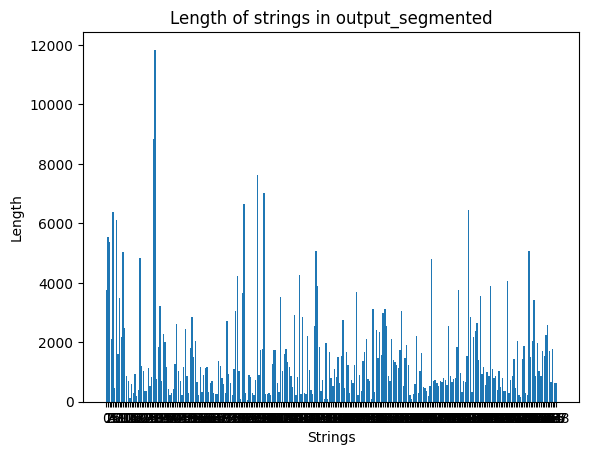

In [61]:
# Preprocessing 1: Segementatioin between 主文(含) and 綜上所述、據上論斷
input_dataset = output_segmented
print("Text length>1500:", over_length(1500, input_dataset))
print("Text length>2000:", over_length(2000, input_dataset))
print("Text length>2500:", over_length(2500, input_dataset))
print("Text length>3000:", over_length(3000, input_dataset))
draw_datasets_bar(output_segmented, "output_segmented")

#### 未經過re處理

Text length>1500: 250
Text length>2000: 217
Text length>2500: 135
Text length>3000: 84
content
average: 2900.3271375464683
max: 12449
min: 884


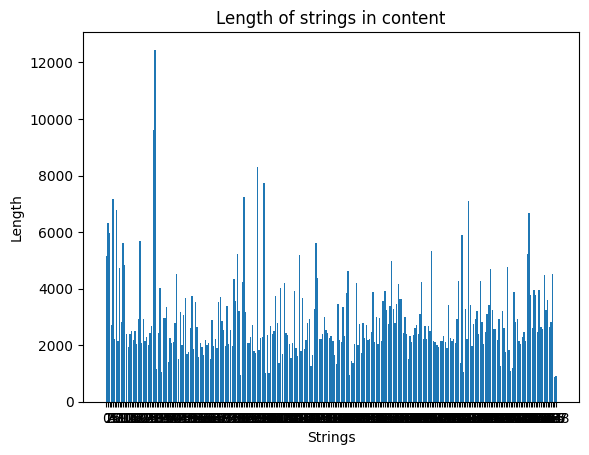

summary
average: 440.9479553903346
max: 1615
min: 60


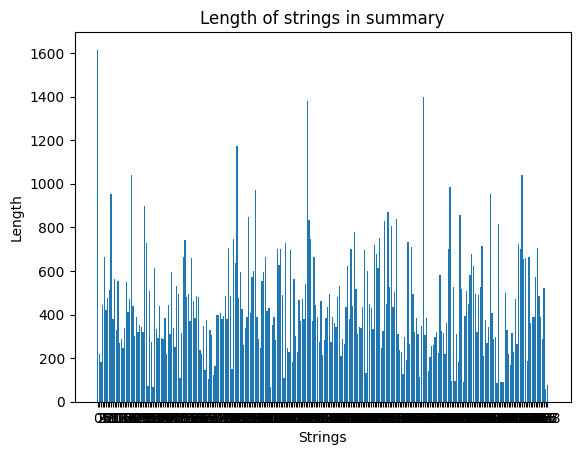

In [63]:
content_list = [jud["content"] for jud in glm_dataset]
summary_list = [jud["summary"] for jud in glm_dataset]

input_dataset = content_list
print("Text length>1500:", over_length(1500, content_list))
print("Text length>2000:", over_length(2000, content_list))
print("Text length>2500:", over_length(2500, content_list))
print("Text length>3000:", over_length(3000, content_list))
draw_datasets_bar(content_list, "content")
draw_datasets_bar(summary_list, "summary")

###  測試多線程

In [9]:
## Final

import os
import json
import csv
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
# 指定根目錄
root_dir = r"D:\juds"
# 輸出目錄
output_dir = r'D:\\output_test'  

# 初始化列名和數據列表
jud_columns = ['JID', 'JYEAR', 'JCASE', 'JNO', 'JDATE', 'JTITLE', 'JFULL', 'JPDF']

# 定義工作函數，處理一個資料夾底下的所有JSON文件
def process_directory(dir_path):
    data = []
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        if os.path.isdir(file_path):
            # 如果是子目錄，遞歸處理
            data.extend(process_directory(file_path))
        elif filename.endswith('.json'):
            # 如果是JSON文件，讀取文件內容並添加到數據列表中
            with open(file_path, 'r', encoding='utf-8') as f:
                json_data = json.load(f)
                row = [json_data[column] for column in jud_columns]
                data.append(row)
    return data

# 定義工作函數，將數據寫入CSV文件中
def write_csv_file(output_path, data):
    splited = output_path.split("\\")
    new_path = "\\".join(splited[0:3])+"\\"+"_".join(splited[3:])
    with open(new_path, 'w', newline='', encoding='utf-8-sig') as f:
        writer = csv.writer(f)
        writer.writerow(jud_columns)
        writer.writerows(data)

# 遍歷根目錄下的所有資料夾，並處理每個資料夾底下的JSON文件
with ThreadPoolExecutor(max_workers=16) as executor:
    for dirpath, dirnames, filenames in os.walk(root_dir):
        futures = []
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            if file_path.endswith('.json'):
                futures.append(executor.submit(process_directory, dirpath))
        results = [f.result() for f in tqdm(futures, desc=dirpath, leave=False) if f.result() != []]

        if results != []:
            # 處理完畢後，將數據寫入CSV文件中
            output_path = os.path.join(output_dir, dirpath.replace(root_dir, '').strip('\\') + '.csv')

            write_csv_file(output_path, results[0])


D:\juds\200404\臺北簡易庭民事:  31%|███       | 766/2484 [08:28<21:26,  1.34it/s]                

In [ ]:
# 取消remove_dir_flag註解，設定目前進行到的資料夾路徑original_dirs，即可刪除重複資料夾
import os
import shutil
# Check csv exists
output_csv_path = r"F:\csv_output"
original_dirs = r"F:\判決書txt\uploaded\202001--(20230416Update)"
# remove_dir_flag = True
def get_file_path(path):
    for path in os.scandir(path):
        if path.is_dir():
            dir_paths.append(path.path)
            get_file_path(path)
        else:
            file_paths.append(path.path)
    return file_paths
dir_paths = []
file_paths = []
get_file_path(original_dirs)
dir_paths = dir_paths[1:]
csv_names = [item.name for item in os.scandir(output_csv_path)]
for dir_path in dir_paths:
    csv_path = "_".join(dir_path.split("\\")[3:])+".csv"
    if csv_path in csv_names and remove_dir_flag:
        shutil.rmtree(dir_path)
        print(csv_path)

### Replace 20230418_merge.json's 
content -> jud<br />
summary -> 摘要如下+original summary

In [ ]:
import os
import re

root_dir = "traffic_datasets"
replace_index = [2, 4, 27, 42, 44, 47, 50, 58, 59, 73, 92, 103, 109, 124]
replace_file_name = []
# ---Read new datasets
merged_list = read_glm_dataset("20230418_merge.json")

# ---Get replace_file_name
replace_filenames = [merged_list[index]["content"] for index in replace_index]
for dirpath, dirnames, filenames in os.walk(root_dir):
    for file in filenames:
        stripped = re.sub("\s+", "", file)
        if stripped in replace_filenames:
            # print("---", replace_filenames.index(stripped), "---")
            replace_file_name.append(os.path.join(dirpath, file))

# Replace content to exact file's content and change summary
new_merged_list = merged_list  
for index, jud_index in enumerate(replace_index):
    
    # print(new_merged_list[jud_index]["content"])
    with open (replace_file_name[index], "r") as txt_file:
        replaced_content = ""
        for line in txt_file:
            # Replace all special unicode or \n \t
            replaced_content += re.sub(r"[\xa0|\u3000| ]", "", line.strip())
    new_merged_list[jud_index]["content"] = replaced_content
    new_merged_list[jud_index]["summary"] = "摘要如下：" + new_merged_list[jud_index]["summary"]
    # print(new_merged_list[jud_index]["content"])
    # print()
    # print(new_merged_list[jud_index]["summary"])
    # print("-------")
    
# # Output new_merged_list to json file
# output_glm_datast("20230419_merge_replaced.json", new_merged_list)

### Processing 0521_merge.txt

In [4]:
# Processing 0521_merge.txt
import re

# # ---Read file to jud_list
# file_name = "0521_merge.txt"
# with open(file_name, "r", encoding="utf-8") as f:
#     file_content = f.read()
#     jud_list = eval(file_content)
# print(len(jud_list))

# # ---Create new_jud_list that matches glm dataset's format
# new_jud_list = []
# replace_index = []
# error_index = []
# for index, jud in enumerate(jud_list):
#     match = re.match("(.+)(摘要如下.+)", jud)   
#     if not match:
#         match = re.match("(.+txt):*(.+)", jud)
#         if not match:
#             error_index.append(index)
#             continue
#         replace_index.append(index)
#     new_data = {"content":match.group(1), "summary":match.group(2)}
#     new_jud_list.append(new_data)

# ---Output new_jud_list as new json file
dataset_name = "20230418_merge.json"
# output_glm_datast(dataset_name, new_jud_list)

# ---Read new datasets
merged = read_glm_dataset(dataset_name)
print("merged:", len(merged))
print(merged[27]["content"])

# print(len(new_jud_list), len(replace_index), len(error_index))
# print(replace_index)

269
<re.Match object; span=(0, 6761), match='01臺灣臺南地方法院刑事判決02109年度交易字第1058號03公訴人臺灣臺南地方檢察署檢察官04>


In [ ]:
#editted
import re
txt_index = []
for index, jud in enumerate(jud_list):
    if re.findall("txt", jud):
        txt_index.append(index)
print(txt_index)

for i in txt_index:
    print(re.findall("(.+?).txt", jud_list[i])[0])

[2, 4, 27, 42, 44, 47, 50, 58, 59, 73, 92, 103, 109, 124]
109,交易,158,20210531,1(1)
109,交易,277,20210531,1(1)
109,竹交簡,954,20201230,1
110,交簡,1743,20210803,1(1)
110,交簡,1933,20210707,1(1)
110,交簡,374,20210705,1(1)
110,交簡,85,20210803,1(1)
110,嘉交簡,635,20210730,1(1)
110,嘉交簡,645,20210730,1(1)
110,東交簡,140,20210802,1(1)
臺灣士林地方法院110年交易字第17號刑事判決(1)
臺灣宜蘭地方法院110年交易字第178號刑事判決(1)
臺灣宜蘭地方法院110年交簡字第405號刑事判決(1)
臺灣新北地方法院106年交易字第167號刑事判決
